# Void size analysis


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

In [2]:
FILE_RE = re.compile(
    r"sample(?P<sample>\d+)_step(?P<step>\d+)_selection\.Label-Analysis\.(csv|tsv|txt)$",
    re.IGNORECASE
)

def discover_hits(base: Path):
    """Find step*/ files matching the naming pattern (non-recursive within each step dir)."""
    hits = []
    for step_dir in sorted([d for d in base.iterdir() if d.is_dir() and re.match(r"^step\d+$", d.name, re.I)],
                           key=lambda p: int(re.search(r"\d+", p.name).group())):
        for f in step_dir.iterdir():
            m = FILE_RE.search(f.name)
            if m:
                hits.append((f, int(m.group("sample")), int(m.group("step"))))
    return hits


def read_label_csv_simple(csv_path: Path, skiprows=4):

    df = pd.read_csv(csv_path, engine="python", sep=None, skiprows=skiprows, on_bad_lines="skip")
    if df.empty:
        raise ValueError(f"No data in {csv_path}")

    df = df.dropna(axis=1, how="all")
    num = df.apply(pd.to_numeric, errors="coerce")

    good = [c for c in num.columns if (1.0 - num[c].isna().mean()) >= 0.5][:2]
    if len(good) < 2:
        good = list(num.columns[:2])
        if len(good) < 2:
            raise ValueError(f"Could not find two numeric columns in {csv_path}")

    a = num[good[0]].dropna().to_numpy()
    b = num[good[1]].dropna().to_numpy()

    n = min(a.size, b.size)
    a, b = a[:n], b[:n]

    a_med, b_med = np.median(a), np.median(b)
    if np.isfinite(a_med) and np.isfinite(b_med):
        if a_med > 3*b_med:
            volumes, diameters = a, b
        elif b_med > 3*a_med:
            volumes, diameters = b, a
        else:
            volumes, diameters = a, b
    else:
        volumes, diameters = a, b

    return volumes.astype(float), diameters.astype(float)


def load_void_data(
    base_dir: Path,
    sample_volume_um3=None,  
    skiprows=4
):

    hits = discover_hits(base_dir)
    samples = sorted({s for _, s, _ in hits})
    steps   = sorted({st for _, _, st in hits})

    per_step_diameters = {f"sample{s}": {} for s in samples}
    per_step_volume    = {f"sample{s}": {} for s in samples}
    per_step_sample_volume = {f"sample{s}": {} for s in samples} if sample_volume_um3 is not None else None

    for csv_path, sample_num, step_num in hits:
        try:
            vols, diams = read_label_csv_simple(csv_path, skiprows=skiprows)
        except Exception as e:
            print(f"[WARN] Skipping {csv_path.name}: {e}")
            continue

        s_key, st_key = f"sample{sample_num}", f"step{step_num}"
        per_step_volume[s_key][st_key]    = vols
        per_step_diameters[s_key][st_key] = diams
        if per_step_sample_volume is not None:
            per_step_sample_volume[s_key][st_key] = float(sample_volume_um3)

    return (per_step_diameters,
            per_step_volume,
            per_step_sample_volume,
            samples, steps)

In [3]:
BASE_DIR = Path(".").resolve()

per_step_diameters, per_step_volume, per_step_sample_volume, samples_present, steps_present = \
    load_void_data(BASE_DIR, skiprows=2)

print("Samples:", samples_present)
print("Steps:", steps_present, "\n")

for s in samples_present:
    for st in steps_present:
        d = per_step_diameters.get(f"sample{s}", {}).get(f"step{st}", [])
        v = per_step_volume.get(f"sample{s}", {}).get(f"step{st}", [])
        if len(d) > 0 and len(v) > 0:
            print(f"sample{s}, step{st}: first diameter = {d[0]:.3f}, first volume = {v[0]:.3f}")
        else:
            print(f"sample{s}, step{st}: no data")

Samples: [1, 2, 3, 4]
Steps: [2, 3, 4, 5] 

sample1, step2: first diameter = 16.583, first volume = 2387.790
sample1, step3: first diameter = 4.873, first volume = 60.578
sample1, step4: first diameter = 6.305, first volume = 131.252
sample1, step5: first diameter = 4.873, first volume = 60.578
sample2, step2: first diameter = 5.363, first volume = 80.771
sample2, step3: first diameter = 5.249, first volume = 75.715
sample2, step4: first diameter = 6.053, first volume = 116.096
sample2, step5: first diameter = 6.539, first volume = 146.382
sample3, step2: first diameter = 8.601, first volume = 333.162
sample3, step3: first diameter = 8.238, first volume = 292.779
sample3, step4: first diameter = 5.130, first volume = 70.671
sample3, step5: first diameter = 4.873, first volume = 60.575
sample4, step2: first diameter = 6.686, first volume = 156.485
sample4, step3: first diameter = 6.385, first volume = 136.294
sample4, step4: first diameter = 4.873, first volume = 60.575
sample4, step5: 

In [4]:
per_step_diameters['sample1']['step5'][0]


4.87273

In [5]:
per_step_volume['sample1']['step5'][0]


60.5781

In [6]:
import pandas as pd, re

def _coerce_float(x):
    """Convert messy numeric strings to float."""
    if pd.isna(x):
        return None
    s = str(x).strip().replace('\u00A0','').replace(' ','')
    # handle comma/point
    if ',' in s and '.' in s:
        if s.rfind(',') > s.rfind('.'):
            s = s.replace('.', '').replace(',', '.')
        else:
            s = s.replace(',', '')
    elif ',' in s and '.' not in s:
        s = s.replace(',', '.')
    # keep only numeric/exponent chars
    s = re.sub(r'[^0-9eE\+\-\.]', '', s)
    try:
        return float(s)
    except Exception:
        return None

def _read_try_delims(path, header=None, verbose=False):
    """
    Try a few common delimiters. Return (df, used_sep).
    We start with sep=None (python engine sniffing), then ',', ';', '\t'.
    """
    for sep in (None, ',', ';', '\t'):
        try:
            df = pd.read_csv(path, engine="python", sep=sep, header=header, on_bad_lines="skip")
            if verbose:
                print(f"[read] sep={repr(sep)} header={header} -> shape={df.shape}")
            # consider it good if we got multiple columns
            if df.shape[1] > 1:
                return df, sep
        except Exception as e:
            if verbose:
                print(f"[read] sep={repr(sep)} failed: {e}")
            continue
    # last resort: whitespace split
    try:
        df = pd.read_csv(path, engine="python", sep=r"\s+", header=header, on_bad_lines="skip")
        if verbose:
            print(f"[read] sep='\\s+' header={header} -> shape={df.shape}")
        return df, r"\s+"
    except Exception as e:
        if verbose:
            print(f"[read] sep='\\s+' failed: {e}")
        raise

def read_total_volume_measure(path, verbose=False):

    df0, used_sep = _read_try_delims(path, header=None, verbose=verbose)
    if verbose:
        print("\n[Preview no-header] first 5 rows:")
        print(df0.head(5))

    if df0.shape[0] >= 3 and df0.shape[1] >= 4:
        v = _coerce_float(df0.iloc[2, 3])  # row 3, col 4 (D3)
        if verbose:
            print(f"[D3 no-header] raw={df0.iloc[2,3]!r} -> parsed={v}")
        if v is not None:
            return v

    df1, used_sep2 = _read_try_delims(path, header=1, verbose=verbose)
    if verbose:
        print("\n[Preview header=1] columns:", list(df1.columns))
        print(df1.head(3))

    df1.columns = [str(c).strip() for c in df1.columns]
    cand = [c for c in df1.columns if re.search(r'total\s*vol', c, re.IGNORECASE)]
    if cand:
        v = _coerce_float(df1.iloc[0][cand[0]])
        if verbose:
            print(f"[header match] column={cand[0]!r} value={df1.iloc[0][cand[0]]!r} -> parsed={v}")
        if v is not None:
            return v

    if df1.shape[0] >= 1 and df1.shape[1] >= 4:
        v = _coerce_float(df1.iloc[0, 3])  # first data row, 4th column
        if verbose:
            print(f"[fallback header=1] firstrow col4 raw={df1.iloc[0,3]!r} -> parsed={v}")
        if v is not None:
            return v

    return None


In [7]:
from pathlib import Path

def load_sample_volumes(base_dir: Path, samples_present, steps_present, verbose=False):
    per_step_sample_volume = {f"sample{s}": {} for s in samples_present}
    for s in samples_present:
        for st in steps_present:
            step_dir = base_dir / f"step{st}"
            measure_path = step_dir / f"totalvolume_sample{s}_step{st}.measure.csv"
            if not measure_path.exists():
                matches = sorted(step_dir.glob(f"totalvolume_sample{s}_step{st}*.measure.csv"))
                measure_path = matches[0] if matches else None

            if not measure_path:
                print(f"[WARN] Missing total volume CSV for sample{s} step{st}")
                continue

            v = read_total_volume_measure(measure_path, verbose=verbose)
            if v is None:
                print(f"[WARN] Could not parse volume from {measure_path.name}")
            per_step_sample_volume[f"sample{s}"][f"step{st}"] = v
    return per_step_sample_volume


In [8]:
per_step_sample_volume = load_sample_volumes(BASE_DIR, samples_present, steps_present)
print(per_step_sample_volume)


{'sample1': {'step2': 338953000.0, 'step3': 336414000.0, 'step4': 339824000.0, 'step5': 337477000.0}, 'sample2': {'step2': 339754000.0, 'step3': 337732000.0, 'step4': 339441000.0, 'step5': 342720000.0}, 'sample3': {'step2': 340060000.0, 'step3': 340339000.0, 'step4': 335716000.0, 'step5': 395875000.0}, 'sample4': {'step2': 339258000.0, 'step3': 346150000.0, 'step4': 336587000.0, 'step5': 339754000.0}}


In [9]:
per_step_sample_volume = load_sample_volumes(BASE_DIR, samples_present, steps_present)

for s in samples_present:
    for st in steps_present:
        print(f"sample{s}, step{st}: sample volume = {per_step_sample_volume[f'sample{s}'].get(f'step{st}')}")


sample1, step2: sample volume = 338953000.0
sample1, step3: sample volume = 336414000.0
sample1, step4: sample volume = 339824000.0
sample1, step5: sample volume = 337477000.0
sample2, step2: sample volume = 339754000.0
sample2, step3: sample volume = 337732000.0
sample2, step4: sample volume = 339441000.0
sample2, step5: sample volume = 342720000.0
sample3, step2: sample volume = 340060000.0
sample3, step3: sample volume = 340339000.0
sample3, step4: sample volume = 335716000.0
sample3, step5: sample volume = 395875000.0
sample4, step2: sample volume = 339258000.0
sample4, step3: sample volume = 346150000.0
sample4, step4: sample volume = 336587000.0
sample4, step5: sample volume = 339754000.0


## Percentage of voids per total number of voids

In [10]:
sample_names = {
    'sample1': 'IA alloy, L-stretched + T-bent',
    'sample2': 'IA alloy, T-stretched + L-bent',
    'sample3': 'No IA alloy, L-stretched + T-bent',
    'sample4': 'No IA alloy, T-stretched + L-bent'
}

legend_order = ['sample1', 'sample2', 'sample3', 'sample4']

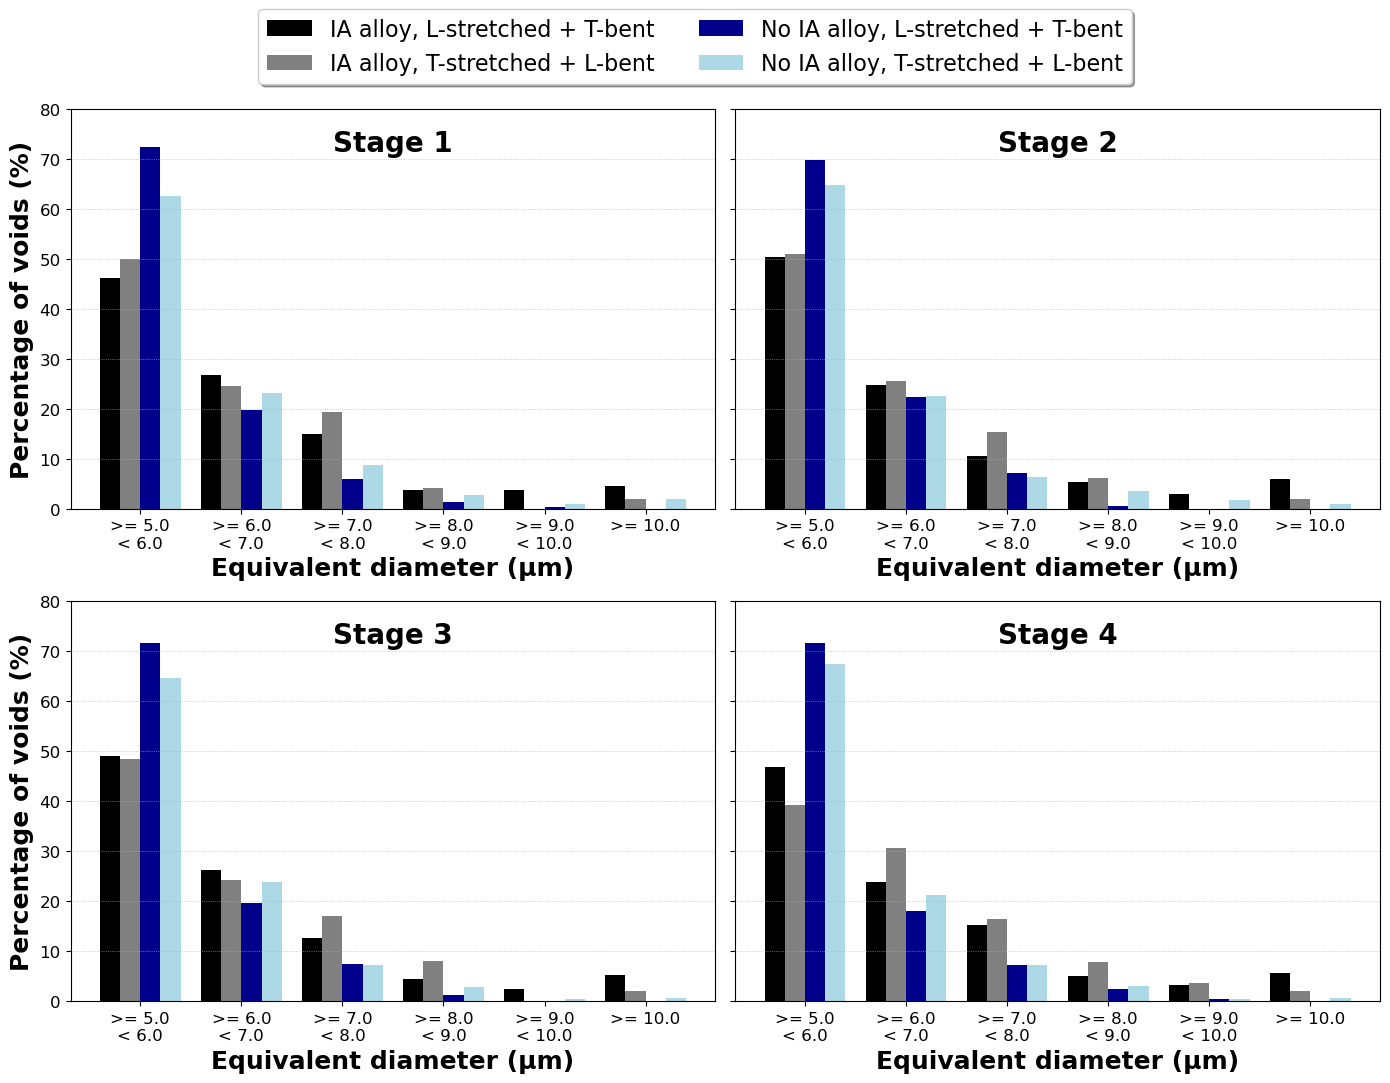

In [11]:
def plot_all_steps(per_step_diameters, steps=('step2','step3','step4','step5')):
    bin_edges = [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf')]
    n_bins = len(bin_edges) - 1
    
    sample_colours = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    axes = axes.flatten()

    for ax_idx, (ax, step_key) in enumerate(zip(axes, steps)):
        samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))
        data = {s: per_step_diameters[s][step_key]
                for s in samples if step_key in per_step_diameters[s] and per_step_diameters[s][step_key].size > 0}
        if not data:
            ax.set_visible(False)
            continue

        pct_by_sample = {}
        for s, vals in data.items():
            counts, _ = np.histogram(vals, bins=bin_edges)
            total = counts.sum()
            pct = (counts / total * 100.0) if total > 0 else np.zeros_like(counts, dtype=float)
            pct_by_sample[s] = pct

        n_series = len(pct_by_sample)
        x = np.arange(n_bins)
        bar_width = 0.8 / max(n_series, 1)

        for i, (s, pct) in enumerate(sorted(pct_by_sample.items(), key=lambda kv: int(kv[0].replace('sample','')))):
            ax.bar(x + i * bar_width - (n_series-1)*bar_width/2,
                   pct, width=bar_width,
                   label=sample_names.get(s, s),
                   color=sample_colours.get(s, None))

        labels = [f">= {bin_edges[i]:.1f}\n< {bin_edges[i+1]:.1f}" for i in range(n_bins-1)]
        labels.append(f">= {bin_edges[-2]:.1f}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels)

        ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=18)
        ax.set_ylim(0, 80)
        ax.grid(axis='y', linestyle=':', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        ax.text(0.5, 0.95, f"Stage {ax_idx + 1}", transform=ax.transAxes, 
                fontweight='bold', fontsize=20, ha='center', va='top')

    axes[0].set_ylabel("Percentage of voids (%)", fontweight='bold', fontsize=18)
    axes[2].set_ylabel("Percentage of voids (%)", fontweight='bold', fontsize=18)
    
    handles_dict = {}
    labels_dict = {}
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            for sample_key, sample_name in sample_names.items():
                if sample_name == label:
                    handles_dict[sample_key] = handle
                    labels_dict[sample_key] = label
                    break
    
    ordered_handles = [handles_dict[key] for key in legend_order if key in handles_dict]
    ordered_labels = [labels_dict[key] for key in legend_order if key in labels_dict]
    
    fig.legend(ordered_handles, ordered_labels, loc="upper center", ncol=2, 
               bbox_to_anchor=(0.5, 1.09), frameon=True, fancybox=True, shadow=True, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_all_steps(per_step_diameters)


## Void volume fraction

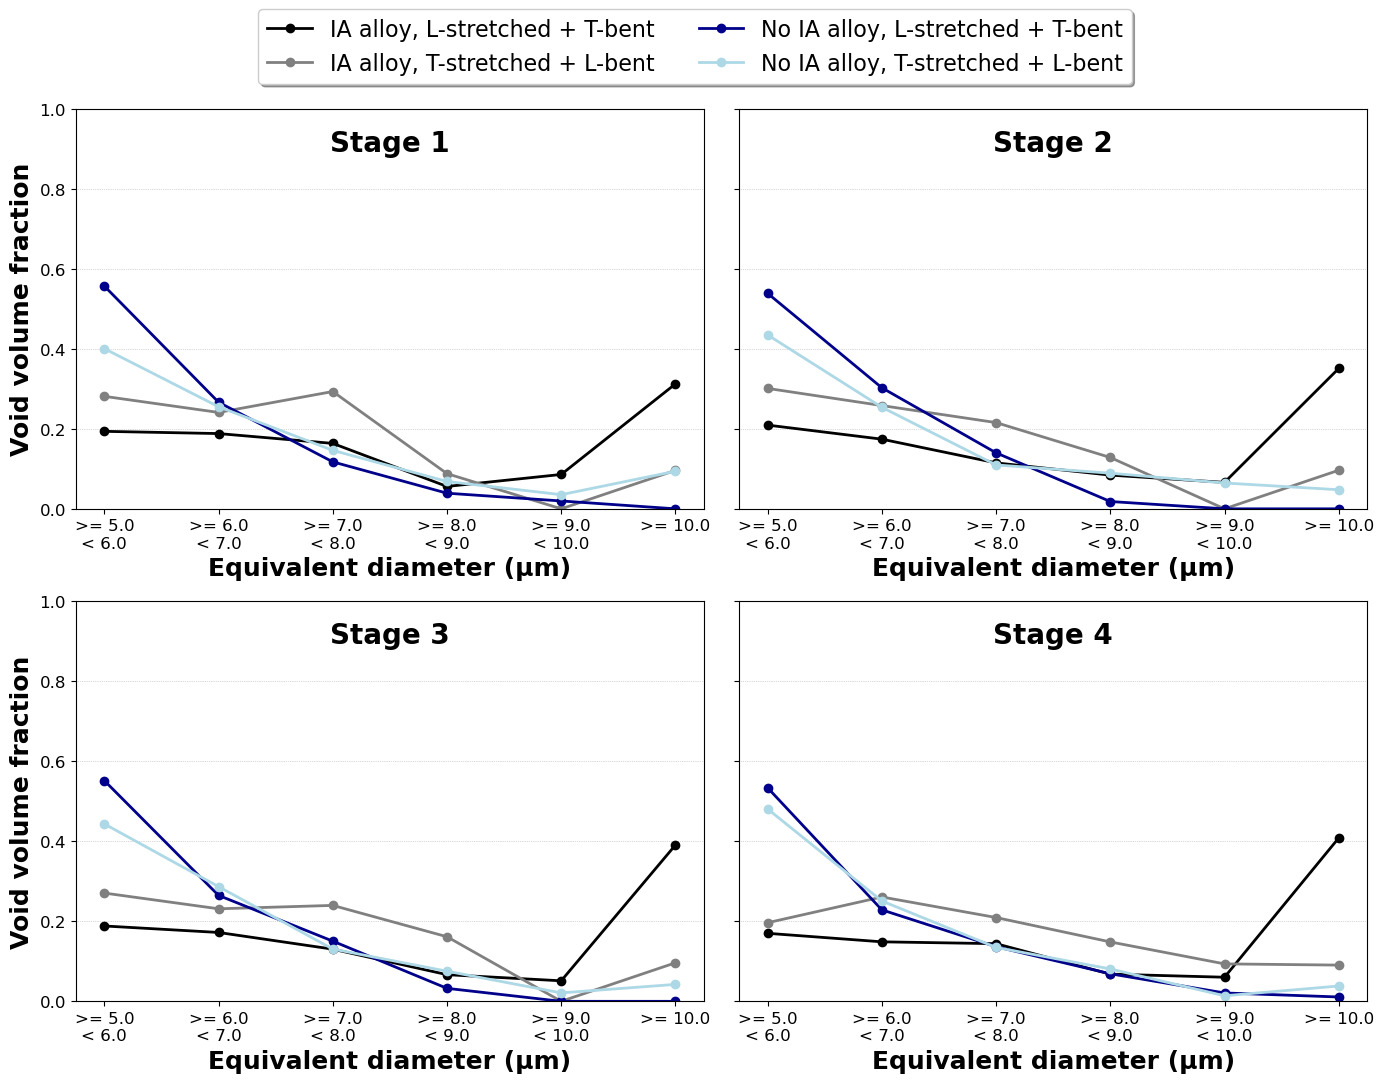

In [12]:
def plot_all_steps_volume_fraction(per_step_diameters, per_step_volume,
                                   steps=('step2','step3','step4','step5'),
                                   ylim=(0, 1.0)):

    import numpy as np
    import matplotlib.pyplot as plt

    bin_edges = [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf')]
    n_bins = len(bin_edges) - 1
    x = np.arange(n_bins)

    sample_colours = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    axes = axes.flatten()

    for ax_idx, (ax, step_key) in enumerate(zip(axes, steps)):
        samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))

        plotted_any = False
        for s in samples:
            if step_key not in per_step_diameters.get(s, {}) or step_key not in per_step_volume.get(s, {}):
                continue

            diams = np.asarray(per_step_diameters[s][step_key]).ravel()
            vols  = np.asarray(per_step_volume[s][step_key]).ravel()
            if diams.size == 0 or vols.size == 0:
                continue

            n = min(diams.size, vols.size)
            diams = diams[:n]
            vols  = vols[:n]
            mask = np.isfinite(diams) & np.isfinite(vols) & (vols >= 0)
            diams = diams[mask]
            vols  = vols[mask]
            if diams.size == 0:
                continue

            vol_sums, _ = np.histogram(diams, bins=bin_edges, weights=vols)
            total_vol = vol_sums.sum()
            frac = (vol_sums / total_vol) if total_vol > 0 else np.zeros(n_bins, dtype=float)

            ax.plot(
                x, frac, marker='o', linestyle='-', linewidth=2,
                color=sample_colours.get(s, None),
                label=sample_names.get(s, s)
            )
            plotted_any = True

        if not plotted_any:
            ax.set_visible(False)
            continue

        labels = [f">= {bin_edges[i]:.1f}\n< {bin_edges[i+1]:.1f}" for i in range(n_bins-1)]
        labels.append(f">= {bin_edges[-2]:.1f}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels)

        ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=18)
        if ylim:
            ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle=':', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.text(0.5, 0.95, f"Stage {ax_idx + 1}", transform=ax.transAxes,
                fontweight='bold', fontsize=20, ha='center', va='top')

    axes[0].set_ylabel("Void volume fraction", fontweight='bold', fontsize=18)
    axes[2].set_ylabel("Void volume fraction", fontweight='bold', fontsize=18)

    handles_dict = {}
    labels_dict = {}
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            for sample_key, sample_name in sample_names.items():
                if sample_name == label:
                    handles_dict[sample_key] = handle
                    labels_dict[sample_key] = label
                    break

    ordered_handles = [handles_dict[key] for key in legend_order if key in handles_dict]
    ordered_labels = [labels_dict[key] for key in legend_order if key in labels_dict]

    if ordered_handles:
        fig.legend(ordered_handles, ordered_labels, loc="upper center", ncol=2,
                   bbox_to_anchor=(0.5, 1.09), frameon=True, fancybox=True, shadow=True, fontsize=16)

    plt.tight_layout()
    plt.savefig("voids_volume_fraction.png", dpi=300, bbox_inches="tight")
    plt.show()

# Run it
plot_all_steps_volume_fraction(per_step_diameters, per_step_volume)


In [13]:

bin_edges = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, np.inf]
n_bins = len(bin_edges) - 1

diams = np.asarray(per_step_diameters['sample1']['step2']).ravel()
vols  = np.asarray(per_step_volume['sample1']['step2']).ravel()

n = min(diams.size, vols.size)
diams, vols = diams[:n], vols[:n]

mask = np.isfinite(diams) & np.isfinite(vols) & (vols >= 0)
diams, vols = diams[mask], vols[mask]

vol_sums, _ = np.histogram(diams, bins=bin_edges, weights=vols)
total_vol = vol_sums.sum()
frac = (vol_sums / total_vol) if total_vol > 0 else np.zeros(n_bins)

labels = [f"{bin_edges[i]}–{bin_edges[i+1]} µm" if np.isfinite(bin_edges[i+1])
          else f">= {bin_edges[i]} µm"
          for i in range(n_bins)]
df = pd.DataFrame({"Bin range": labels, "Volume fraction": frac})

print(df.to_string(index=False))


Bin range  Volume fraction
   5–6 µm         0.193809
   6–7 µm         0.188233
   7–8 µm         0.163622
   8–9 µm         0.055951
  9–10 µm         0.085945
 10–11 µm         0.077870
 11–12 µm         0.000000
 12–13 µm         0.000000
 13–14 µm         0.000000
 14–15 µm         0.062872
 15–16 µm         0.080754
 16–17 µm         0.090944
 17–18 µm         0.000000
 18–19 µm         0.000000
 19–20 µm         0.000000
 >= 20 µm         0.000000


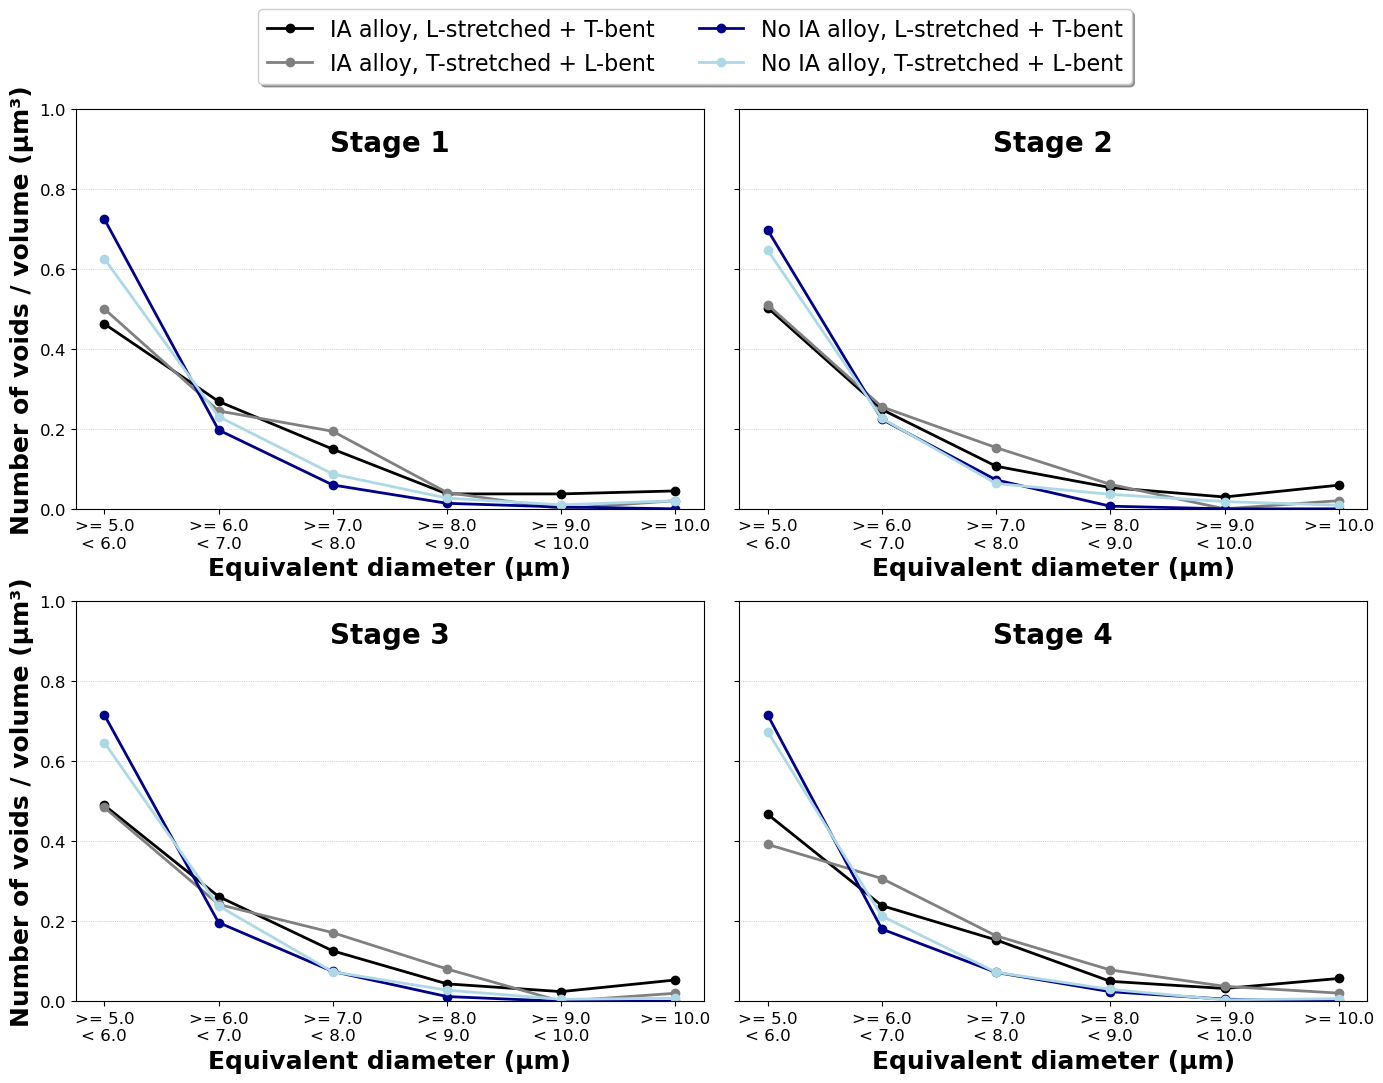

In [14]:
def plot_all_steps_void_counts(per_step_diameters, per_step_volume,
                               steps=('step2','step3','step4','step5'),
                               ylim=(0, 1.0)):
    bin_edges = [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf')]
    n_bins = len(bin_edges) - 1
    x = np.arange(n_bins)

    sample_colours = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    axes = axes.flatten()

    for ax_idx, (ax, step_key) in enumerate(zip(axes, steps)):
        samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))

        plotted_any = False
        for s in samples:
            if step_key not in per_step_diameters[s]:
                continue
            diams = np.asarray(per_step_diameters[s][step_key]).ravel()

            if diams.size == 0:
                continue

            counts, _ = np.histogram(diams, bins=bin_edges)
            total_count = counts.sum()
            frac = (counts / total_count) if total_count > 0 else np.zeros(n_bins)

            ax.plot(
                x, frac, marker='o', linestyle='-', linewidth=2,
                color=sample_colours.get(s, None),
                label=sample_names.get(s, s)
            )
            plotted_any = True

        if not plotted_any:
            ax.set_visible(False)
            continue

        labels = [f">= {bin_edges[i]:.1f}\n< {bin_edges[i+1]:.1f}" for i in range(n_bins-1)]
        labels.append(f">= {bin_edges[-2]:.1f}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels)

        ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=18)
        if ylim:
            ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle=':', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        ax.text(0.5, 0.95, f"Stage {ax_idx + 1}", transform=ax.transAxes, 
                fontweight='bold', fontsize=20, ha='center', va='top')

    axes[0].set_ylabel("Number of voids / volume (µm³)", fontweight='bold', fontsize=18)
    axes[2].set_ylabel("Number of voids / volume (µm³)", fontweight='bold', fontsize=18)

    handles_dict = {}
    labels_dict = {}
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            for sample_key, sample_name in sample_names.items():
                if sample_name == label:
                    handles_dict[sample_key] = handle
                    labels_dict[sample_key] = label
                    break
    
    ordered_handles = [handles_dict[key] for key in legend_order if key in handles_dict]
    ordered_labels = [labels_dict[key] for key in legend_order if key in labels_dict]
    
    if ordered_handles:
        fig.legend(ordered_handles, ordered_labels, loc="upper center", ncol=2, 
                   bbox_to_anchor=(0.5, 1.09), frameon=True, fancybox=True, shadow=True, fontsize=16)

    plt.tight_layout()
    plt.savefig("voids_count_fraction.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_all_steps_void_counts(per_step_diameters, per_step_volume)


In [15]:
def plot_all_steps_void_counts(
    per_step_diameters,
    per_step_sample_volume,                 
    steps=('step2','step3','step4','step5'),
    ylim=None,
    bin_edges=(5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf'))
):
    import numpy as np
    import matplotlib.pyplot as plt

    bin_edges = list(bin_edges)
    n_bins = len(bin_edges) - 1
    x = np.arange(n_bins)

    sample_colours = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    axes = axes.flatten()

    for ax_idx, (ax, step_key) in enumerate(zip(axes, steps)):
        samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))
        plotted_any = False

        for s in samples:
            if step_key not in per_step_diameters.get(s, {}) or step_key not in per_step_sample_volume.get(s, {}):
                continue

            diams = np.asarray(per_step_diameters[s][step_key]).ravel()
            if diams.size == 0:
                continue

            sample_vol_um3 = per_step_sample_volume[s][step_key]
            if sample_vol_um3 is None or not np.isfinite(sample_vol_um3) or sample_vol_um3 <= 0:
                continue

            counts, _ = np.histogram(diams, bins=bin_edges)

            density = counts / float(sample_vol_um3)

            ax.plot(
                x, density, marker='o', linestyle='-', linewidth=2,
                color=sample_colours.get(s, None),
                label=sample_names.get(s, s)
            )
            plotted_any = True

        if not plotted_any:
            ax.set_visible(False)
            continue

        labels = [f">= {bin_edges[i]:.1f}\n< {bin_edges[i+1]:.1f}" for i in range(n_bins-1)]
        labels.append(f">= {bin_edges[-2]:.1f}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels)

        ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=18)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle=':', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.text(0.5, 0.95, f"Stage {ax_idx + 1}", transform=ax.transAxes,
                fontweight='bold', fontsize=20, ha='center', va='top')

    axes[0].set_ylabel("Number of voids per µm³", fontweight='bold', fontsize=18)
    axes[2].set_ylabel("Number of voids per µm³", fontweight='bold', fontsize=18)

    handles_dict, labels_dict = {}, {}
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            for sample_key, sample_name in sample_names.items():
                if sample_name == label:
                    handles_dict[sample_key] = handle
                    labels_dict[sample_key] = label
                    break

    ordered_handles = [handles_dict[key] for key in legend_order if key in handles_dict]
    ordered_labels  = [labels_dict[key]  for key in legend_order if key in labels_dict]

    if ordered_handles:
        fig.legend(ordered_handles, ordered_labels, loc="upper center", ncol=2,
                   bbox_to_anchor=(0.5, 1.09), frameon=True, fancybox=True, shadow=True, fontsize=16)

    plt.tight_layout()
    plt.savefig("voids_number_density_by_bin.png", dpi=300, bbox_inches="tight")
    plt.show()


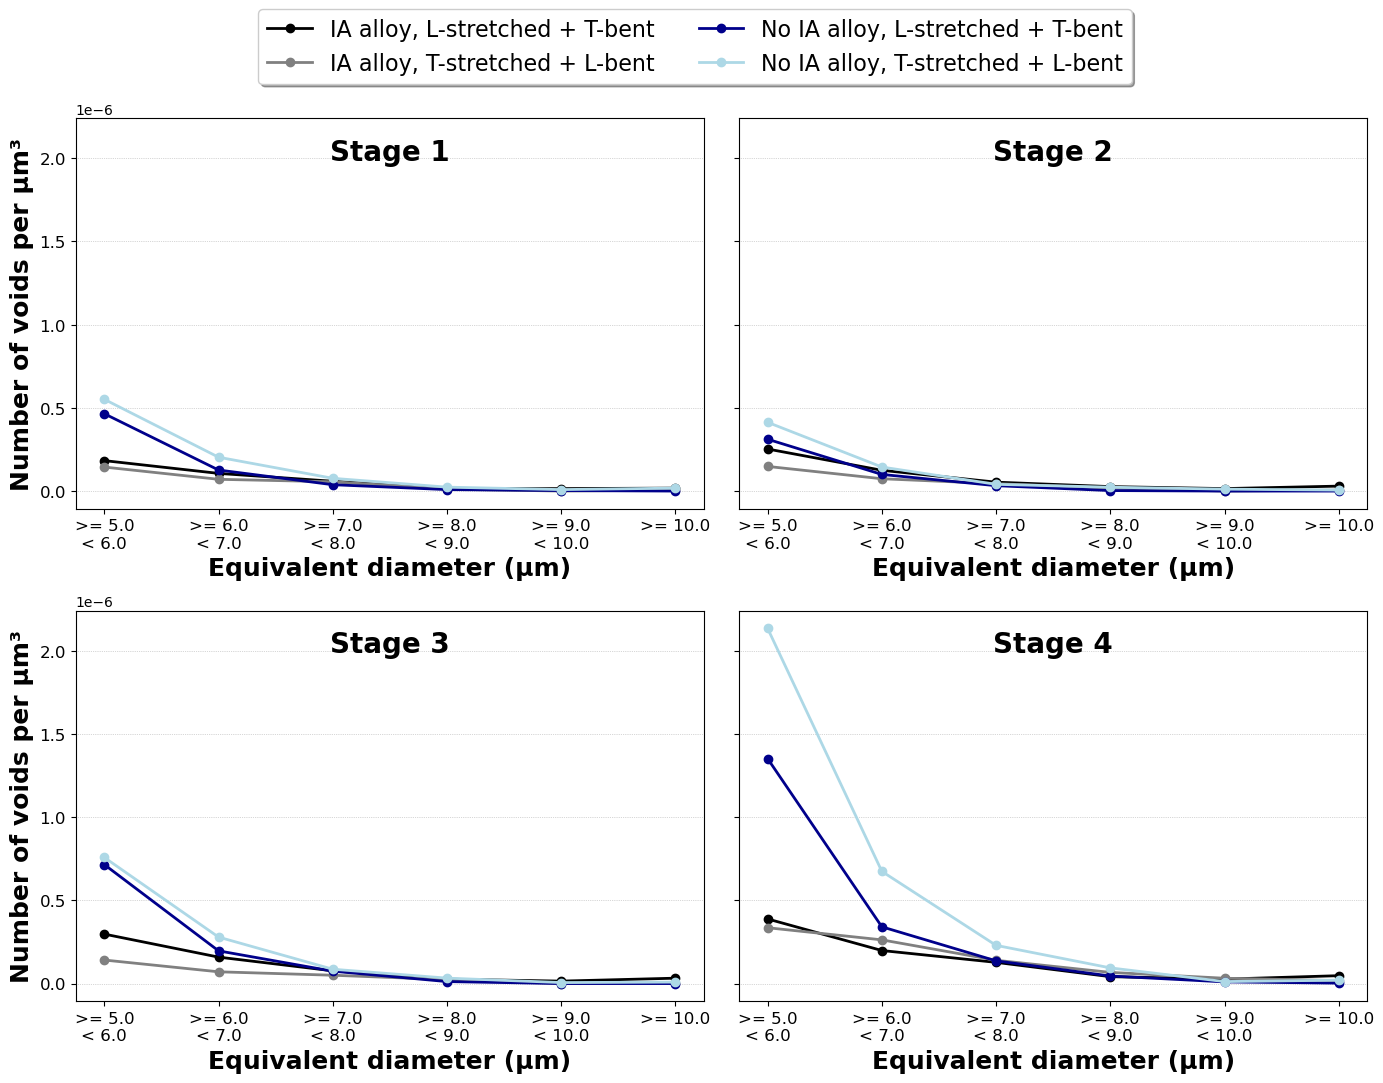

In [16]:
plot_all_steps_void_counts(
    per_step_diameters=per_step_diameters,
    per_step_sample_volume=per_step_sample_volume,   
    steps=tuple(f"step{st}" for st in steps_present),
    ylim=None,  # or e.g. (0, 2e-7)
    bin_edges=(5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf'))
)


In [17]:
def plot_all_steps_void_volume_fraction_per_sample_volume(
    per_step_diameters,
    per_step_volume,         
    per_step_sample_volume,   
    steps=('step2','step3','step4','step5'),
    ylim=None,             
    bin_edges=(5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf')),
    as_percent=False          
):


    bin_edges = list(bin_edges)
    n_bins = len(bin_edges) - 1
    x = np.arange(n_bins)

    sample_colours = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    axes = axes.flatten()

    for ax_idx, (ax, step_key) in enumerate(zip(axes, steps), start=1):
        samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))
        plotted_any = False

        for s in samples:
            if (step_key not in per_step_diameters.get(s, {}) or
                step_key not in per_step_volume.get(s, {}) or
                step_key not in per_step_sample_volume.get(s, {})):
                continue

            diams = np.asarray(per_step_diameters[s][step_key]).ravel()
            vols  = np.asarray(per_step_volume[s][step_key]).ravel()
            sv    = per_step_sample_volume[s][step_key]

            if diams.size == 0 or vols.size == 0 or sv is None or not np.isfinite(sv) or sv <= 0:
                continue

            n = min(diams.size, vols.size)
            diams, vols = diams[:n], vols[:n]
            mask = np.isfinite(diams) & np.isfinite(vols) & (vols >= 0)
            diams, vols = diams[mask], vols[mask]
            if diams.size == 0:
                continue

            vol_sums, _ = np.histogram(diams, bins=bin_edges, weights=vols)

            frac = vol_sums / float(sv)  

            if as_percent:
                y = frac * 100.0
            else:
                y = frac

            ax.plot(
                x, y, marker='o', linestyle='-', linewidth=2,
                color=sample_colours.get(s, None),
                label=sample_names.get(s, s) if 'sample_names' in globals() else s
            )
            plotted_any = True

        if not plotted_any:
            ax.set_visible(False)
            continue

        labels = [f">= {bin_edges[i]:.1f}\n< {bin_edges[i+1]:.1f}" for i in range(n_bins-1)]
        labels.append(f">= {bin_edges[-2]:.1f}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=12)

        ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=16)

        if ylim is not None:
            ax.set_ylim(*ylim)

        ax.grid(axis='y', linestyle=':', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.text(
            0.5, 0.95, f"Stage {ax_idx}",
            transform=ax.transAxes,
            fontweight='bold', fontsize=18,
            ha='center', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)
        )

    ylab = "Void volume fraction"
    if as_percent:
        ylab += " (%)"
    axes[0].set_ylabel(ylab, fontweight='bold', fontsize=16)
    axes[2].set_ylabel(ylab, fontweight='bold', fontsize=16)

    handles_dict, labels_dict = {}, {}
    for ax in axes:
        if not ax.get_visible():
            continue
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            handles_dict[label] = handle
            labels_dict[label] = label

    if handles_dict:
        fig.legend(
            handles_dict.values(), labels_dict.keys(),
            loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.08),
            frameon=True, fontsize=14
        )

    plt.tight_layout()
    plt.savefig("voids_volume_fraction_per_sample_volume.png", dpi=300, bbox_inches="tight")
    plt.show()


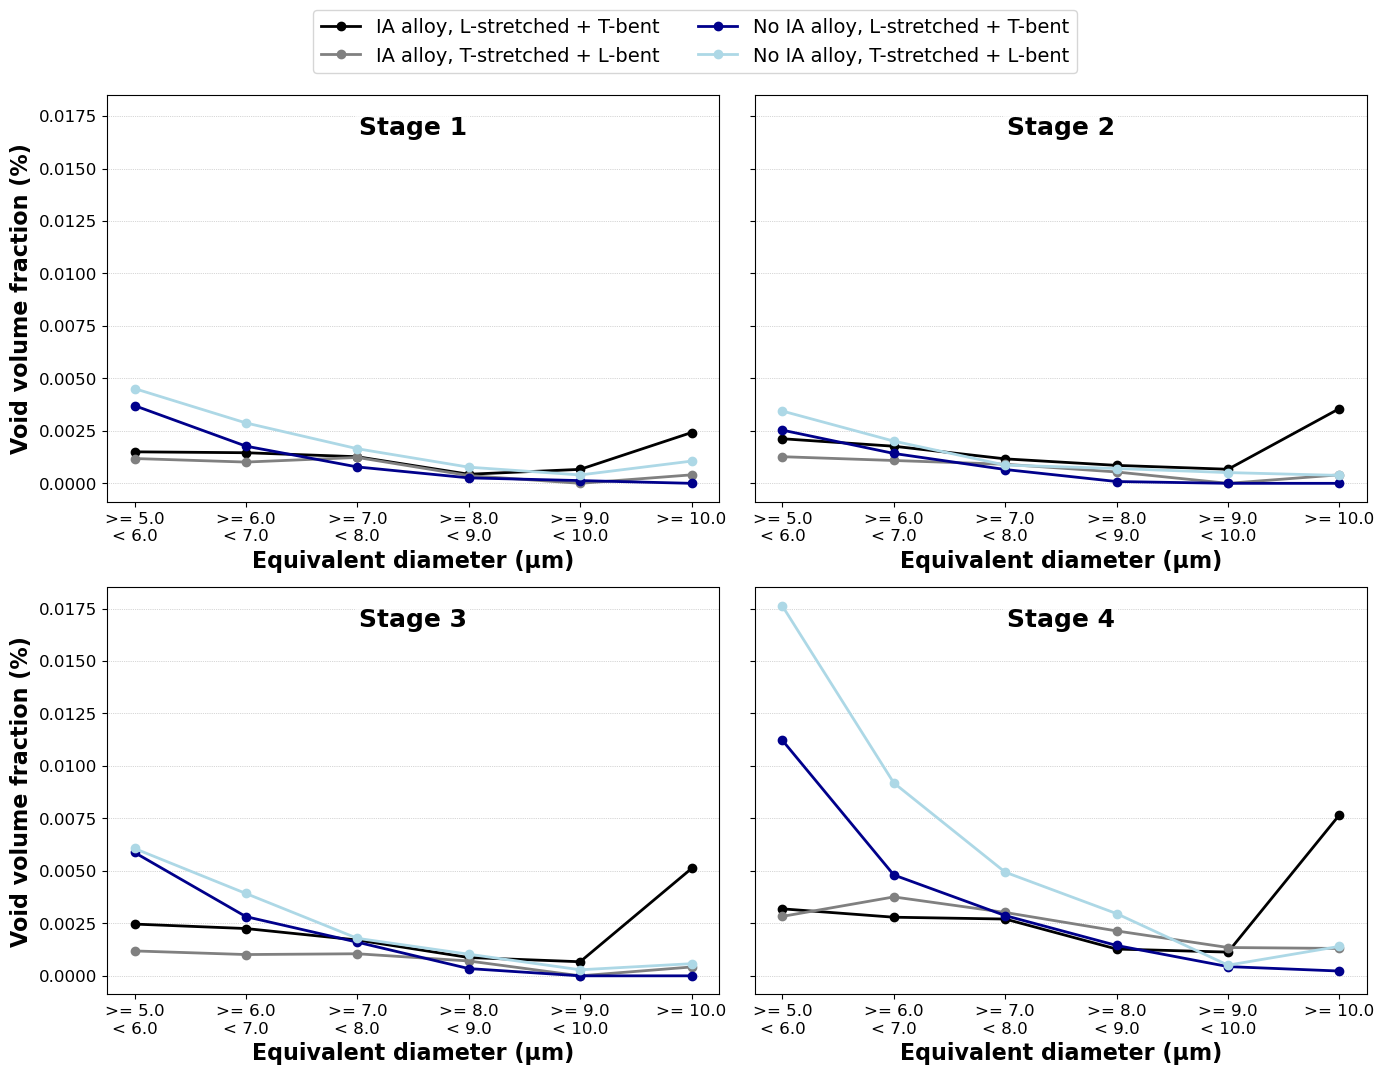

In [18]:
plot_all_steps_void_volume_fraction_per_sample_volume(
    per_step_diameters=per_step_diameters,
    per_step_volume=per_step_volume,                 
    per_step_sample_volume=per_step_sample_volume,   
    steps=tuple(f"step{st}" for st in steps_present),
    ylim=None,             
    bin_edges=(5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf')),
    as_percent=True        
)



In [19]:
def plot_normalised_void_volume_fraction_by_stage(
    per_step_volume,
    per_step_sample_volume,
    steps=('step2','step3','step4','step5'),
    ylim=(0, 1.0)
):

    sample_names = {
        "sample1": "IA alloy, L-stretched + T-bent",
        "sample2": "IA alloy, T-stretched + L-bent",
        "sample3": "No IA alloy, L-stretched + T-bent",
        "sample4": "No IA alloy, T-stretched + L-bent"
    }

    sample_colors = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    samples = sorted(per_step_volume.keys(), key=lambda s: int(s.replace('sample','')))

    x = np.arange(1, len(steps) + 1)
    xlabels = [f"Stage {i}" for i in x]

    fig, ax = plt.subplots(figsize=(8, 6))
    plotted_any = False

    for s in samples:
        raw_fracs = []
        for step_key in steps:
            vols = np.asarray(per_step_volume.get(s, {}).get(step_key, []))
            sv   = per_step_sample_volume.get(s, {}).get(step_key, None)

            if vols.size == 0 or sv is None or not np.isfinite(sv) or sv <= 0:
                raw_fracs.append(0.0)
                continue

            vols = vols[np.isfinite(vols) & (vols >= 0)]
            frac = vols.sum() / float(sv) if vols.size > 0 else 0.0
            raw_fracs.append(frac)

        total = sum(raw_fracs)
        if total <= 0:
            continue

        normed = [f / total for f in raw_fracs]

        ax.plot(
            x, normed, marker='o', linestyle='-', linewidth=2,
            color=sample_colors.get(s, None), label=sample_names.get(s, s)
        )
        plotted_any = True

    if not plotted_any:
        plt.close(fig)
        return

    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, fontsize=14)
    ax.set_xlabel("Bending stage", fontweight='bold', fontsize=16)

    ax.set_ylabel("Normalised void volume fraction", fontweight='bold', fontsize=16)

    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.grid(axis='y', linestyle=':', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(frameon=True, fontsize=12, loc="upper left")

    plt.tight_layout()
    plt.savefig("normalised_voids_volume_fraction_by_stage.png", dpi=300, bbox_inches="tight")
    plt.show()


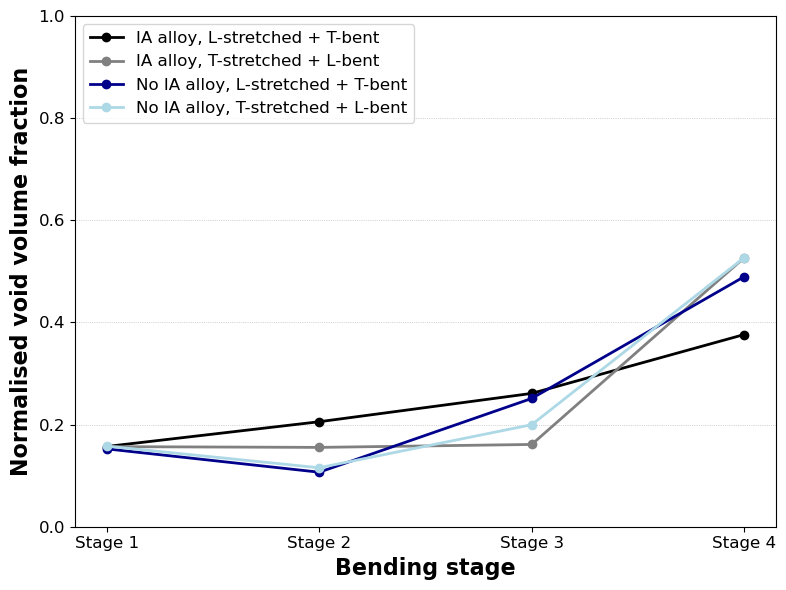

In [20]:
plot_normalised_void_volume_fraction_by_stage(
    per_step_volume=per_step_volume,                 # per-void volumes (µm³)
    per_step_sample_volume=per_step_sample_volume,   # analysed sample volumes (µm³) from your .measure.csv
    steps=tuple(f"step{st}" for st in steps_present),
    ylim=(0, 1)
)


In [21]:
def plot_void_volume_fraction_by_stage_dualaxis(
    per_step_volume,           
    per_step_sample_volume,    
    steps=('step2','step3','step4','step5'),
    ylim_abs=None,      
    ylim_norm=(0, 1.0)   
):


    sample_names = {
        "sample1": "IA alloy, L-stretched + T-bent",
        "sample2": "IA alloy, T-stretched + L-bent",
        "sample3": "No IA alloy, L-stretched + T-bent",
        "sample4": "No IA alloy, T-stretched + L-bent"
    }

    sample_colors = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    samples = sorted(per_step_volume.keys(), key=lambda s: int(s.replace('sample','')))
    x = np.arange(1, len(steps) + 1)
    xlabels = [f"Stage {i}" for i in x]

    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax2 = ax1.twinx()  

    for s in samples:
        abs_vals = []
        for step_key in steps:
            vols = np.asarray(per_step_volume.get(s, {}).get(step_key, []))
            sv   = per_step_sample_volume.get(s, {}).get(step_key, None)
            if vols.size == 0 or sv is None or not np.isfinite(sv) or sv <= 0:
                abs_vals.append(0.0)
                continue
            vols = vols[np.isfinite(vols) & (vols >= 0)]
            frac = vols.sum() / float(sv) if vols.size > 0 else 0.0
            abs_vals.append(frac)


        total = sum(abs_vals)
        normed = [v/total if total > 0 else 0.0 for v in abs_vals]

        ax1.plot(x, abs_vals, marker='o', linestyle='-', linewidth=2,
                 color=sample_colors.get(s, None), label=sample_names.get(s, s))
        ax2.plot(x, normed, marker='s', linestyle='--', linewidth=1.5,
                 color=sample_colors.get(s, None))

    ax1.set_xticks(x)
    ax1.set_xticklabels(xlabels, fontsize=14)
    ax1.set_xlabel("Bending stage", fontweight='bold', fontsize=16)

    ax1.set_ylabel("Void volume fraction", fontweight='bold', fontsize=16, color='black')
    if ylim_abs is not None:
        ax1.set_ylim(*ylim_abs)

    ax2.set_ylabel("Normalised void volume fraction", fontweight='bold', fontsize=16, color='black')
    if ylim_norm is not None:
        ax2.set_ylim(*ylim_norm)

    ax1.grid(axis='y', linestyle=':', linewidth=0.5)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    ax1.legend(frameon=True, fontsize=12, loc="upper left")

    plt.tight_layout()
    plt.savefig("voids_volume_fraction_dualaxis.png", dpi=300, bbox_inches="tight")
    plt.show()


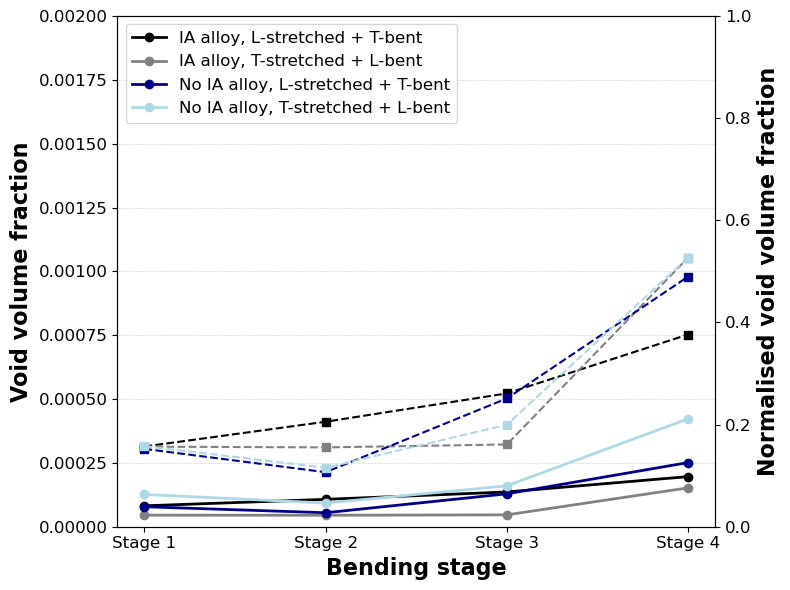

In [22]:
plot_void_volume_fraction_by_stage_dualaxis(
    per_step_volume,
    per_step_sample_volume,
    steps=('step2','step3','step4','step5'),
    ylim_abs=(0, 0.002),
    ylim_norm=(0, 1.0)    
)

In [23]:
for s in sorted(per_step_volume.keys()):
    print(f"\n{s}:")
    for st in ('step2','step3','step4','step5'):
        vols = per_step_volume.get(s, {}).get(st, [])
        sv   = per_step_sample_volume.get(s, {}).get(st, None)
        if len(vols) > 0 and sv is not None and sv > 0:
            frac = np.sum(vols) / float(sv)
            print(f"  {st}: void volume fraction = {frac:.4e}")



sample1:
  step2: void volume fraction = 8.1899e-05
  step3: void volume fraction = 1.0719e-04
  step4: void volume fraction = 1.3610e-04
  step5: void volume fraction = 1.9621e-04

sample2:
  step2: void volume fraction = 4.5288e-05
  step3: void volume fraction = 4.4867e-05
  step4: void volume fraction = 4.6530e-05
  step5: void volume fraction = 1.5216e-04

sample3:
  step2: void volume fraction = 7.8199e-05
  step3: void volume fraction = 5.4760e-05
  step4: void volume fraction = 1.2885e-04
  step5: void volume fraction = 2.5120e-04

sample4:
  step2: void volume fraction = 1.2656e-04
  step3: void volume fraction = 9.2558e-05
  step4: void volume fraction = 1.6019e-04
  step5: void volume fraction = 4.2252e-04


In [24]:
def plot_normalised_void_volume_fraction(
    per_step_diameters,
    per_step_volume,        
    steps=('step2','step3','step4','step5'),
    ylim=(0, 1.0),      
    bin_edges=(5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf'))
):

    bin_edges = list(bin_edges)
    n_bins = len(bin_edges) - 1
    x = np.arange(n_bins)

    sample_colours = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    axes = axes.flatten()

    for ax_idx, (ax, step_key) in enumerate(zip(axes, steps), start=1):
        samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace("sample", "")))
        plotted_any = False

        for s in samples:
            if step_key not in per_step_diameters.get(s, {}) or step_key not in per_step_volume.get(s, {}):
                continue

            diams = np.asarray(per_step_diameters[s][step_key]).ravel()
            vols  = np.asarray(per_step_volume[s][step_key]).ravel()
            if diams.size == 0 or vols.size == 0:
                continue

            n = min(diams.size, vols.size)
            diams, vols = diams[:n], vols[:n]
            mask = np.isfinite(diams) & np.isfinite(vols) & (vols >= 0)
            diams, vols = diams[mask], vols[mask]
            if diams.size == 0:
                continue

            vol_sums, _ = np.histogram(diams, bins=bin_edges, weights=vols)
            total_vol = vol_sums.sum()

            frac = (vol_sums / total_vol) if total_vol > 0 else np.zeros(n_bins)

            ax.plot(
                x, frac, marker="o", linestyle="-", linewidth=2,
                color=sample_colours.get(s, None),
                label=sample_names.get(s, s) if "sample_names" in globals() else s
            )
            plotted_any = True

        if not plotted_any:
            ax.set_visible(False)
            continue

        labels = [f">= {bin_edges[i]:.1f}\n< {bin_edges[i+1]:.1f}" for i in range(n_bins-1)]
        labels.append(f">= {bin_edges[-2]:.1f}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=12)

        ax.set_xlabel("Equivalent diameter (µm)", fontweight="bold", fontsize=16)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(axis="y", linestyle=":", linewidth=0.5)
        ax.tick_params(axis="both", which="major", labelsize=12)

        ax.text(
            0.5, 0.95, f"Stage {ax_idx}",
            transform=ax.transAxes,
            fontweight="bold", fontsize=18,
            ha="center", va="top",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=2)
        )

    axes[0].set_ylabel("Normalised void volume fraction", fontweight="bold", fontsize=16)
    axes[2].set_ylabel("Normalised void volume fraction", fontweight="bold", fontsize=16)

    handles_dict, labels_dict = {}, {}
    for ax in axes:
        if not ax.get_visible():
            continue
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            handles_dict[label] = handle
            labels_dict[label] = label

    if handles_dict:
        fig.legend(
            handles_dict.values(), labels_dict.keys(),
            loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.08),
            frameon=True, fontsize=14
        )

    plt.tight_layout()
    plt.savefig("normalised_voids_volume_fraction.png", dpi=300, bbox_inches="tight")
    plt.show()


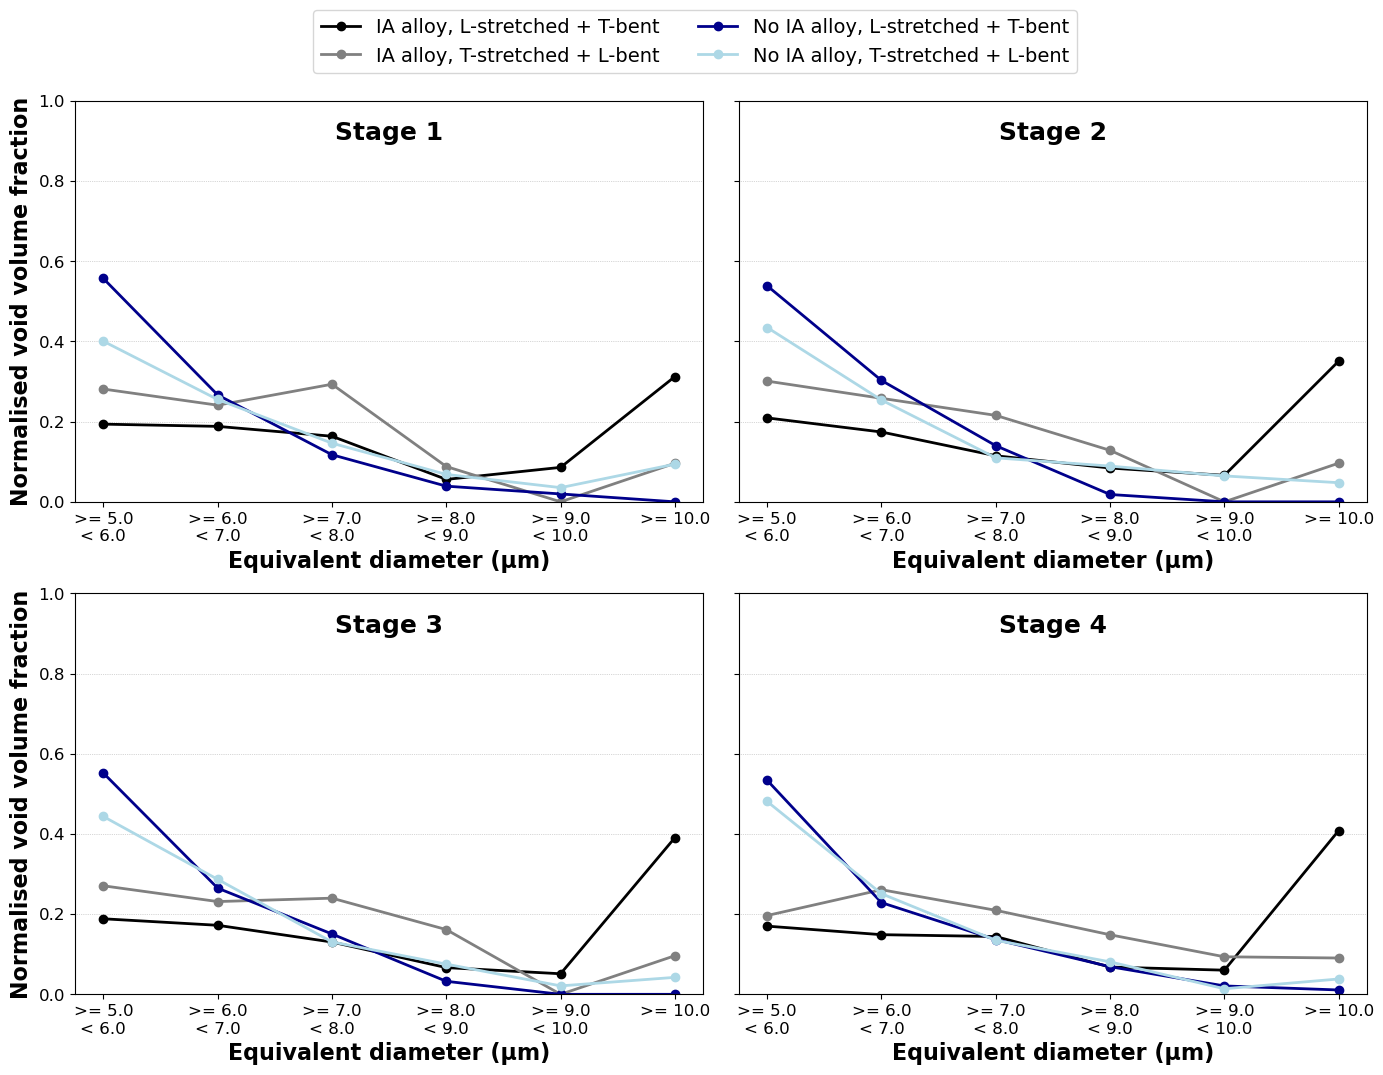

In [25]:
plot_normalised_void_volume_fraction(
    per_step_diameters=per_step_diameters,
    per_step_volume=per_step_volume,
    steps=tuple(f"step{st}" for st in steps_present),
    ylim=(0, 1.0)
)


In [26]:
def plot_void_number_density_per_diameter_per_stage(
    per_step_diameters,
    per_step_sample_volume,                 
    steps=('step2','step3','step4','step5'),
    bin_edges=(5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf')),
    ylim=None
):
    bin_edges = list(bin_edges)
    n_bins = len(bin_edges) - 1
    x = np.arange(n_bins)
    sample_colors = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    def _bin_labels(edges):
        labels = [f">= {edges[i]:.1f}\n< {edges[i+1]:.1f}" for i in range(len(edges)-2)]
        labels.append(f">= {edges[-2]:.1f}")
        return labels

    samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))

    for idx, step_key in enumerate(steps, start=1):
        fig, ax = plt.subplots(figsize=(9, 7))
        plotted_any = False

        for s in samples:
            if step_key not in per_step_diameters.get(s, {}) or step_key not in per_step_sample_volume.get(s, {}):
                continue

            diams = np.asarray(per_step_diameters[s][step_key]).ravel()
            diams = diams[np.isfinite(diams)]
            sample_vol_um3 = per_step_sample_volume[s][step_key]

            if diams.size == 0 or sample_vol_um3 is None or not np.isfinite(sample_vol_um3) or sample_vol_um3 <= 0:
                continue

            counts, _ = np.histogram(diams, bins=bin_edges)

            density = counts / float(sample_vol_um3)

            ax.plot(
                x, density, marker='o', linestyle='-', linewidth=2,
                color=sample_colors.get(s, None),
                label=(sample_names.get(s, s) if 'sample_names' in globals() else s)
            )
            plotted_any = True

        if not plotted_any:
            plt.close(fig)
            continue

        ax.set_xticks(x)
        ax.set_xticklabels(_bin_labels(bin_edges), fontsize=16)

        ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=20)
        ax.set_ylabel("Number of voids per µm³", fontweight='bold', fontsize=20)

        if ylim is not None:
            ax.set_ylim(*ylim)

        ax.grid(axis='y', linestyle=':', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=16)

        fig.suptitle(
            f"Stage {idx}", fontsize=22, fontweight='bold', y=0.97
        )

        ax.legend(
            loc='upper right', fontsize=18, frameon=True
        )

        plt.tight_layout()
        plt.savefig(f"void_number_density_per_diameter_{step_key}.png", dpi=300, bbox_inches="tight")
        plt.show()


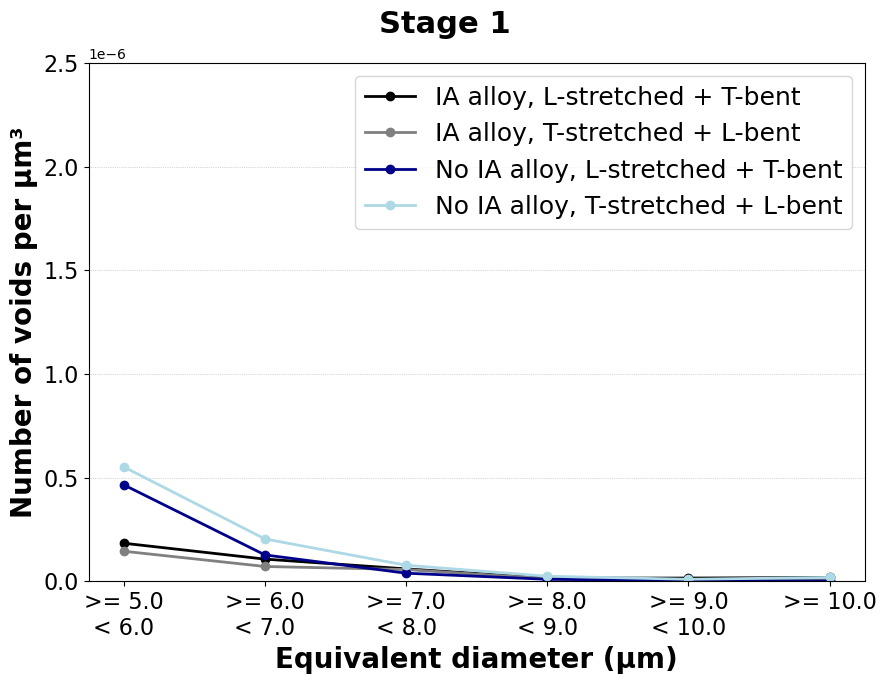

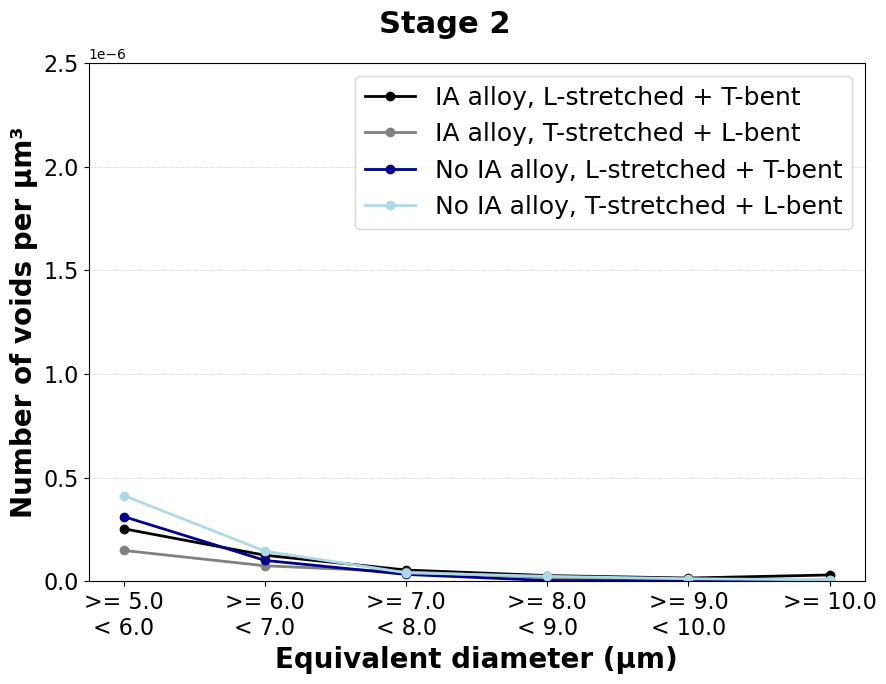

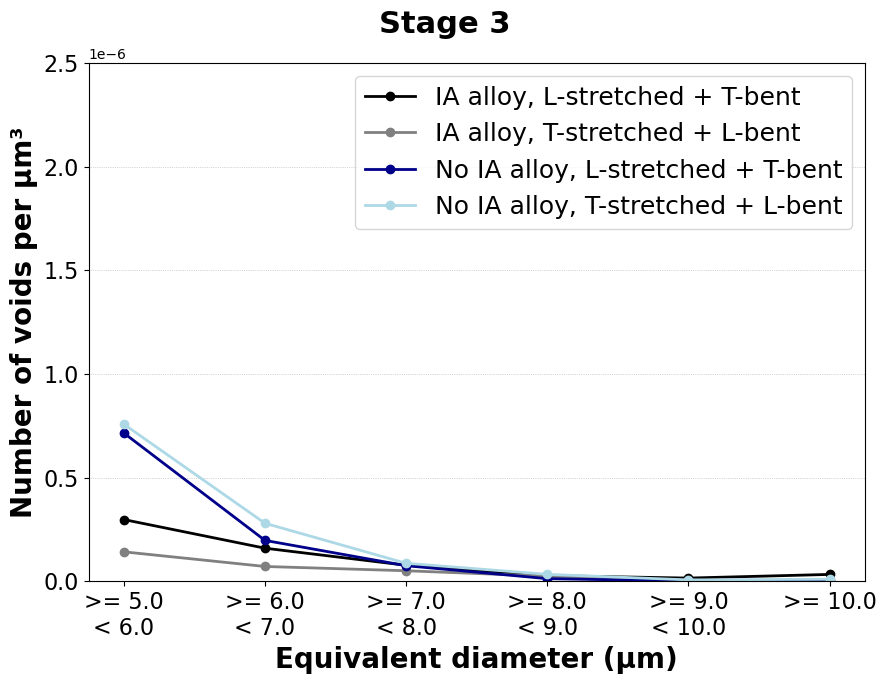

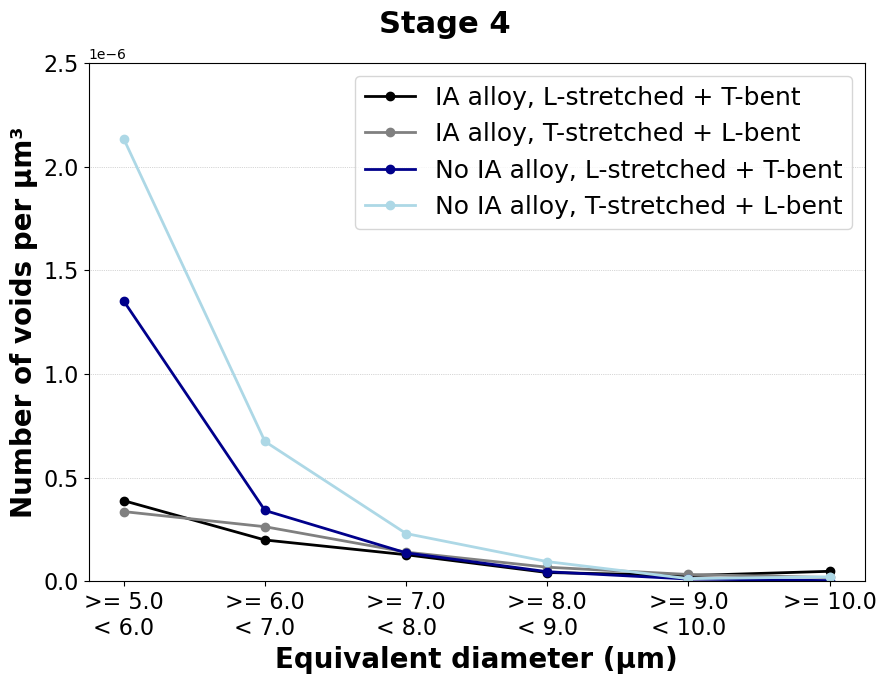

In [27]:
plot_void_number_density_per_diameter_per_stage(
    per_step_diameters=per_step_diameters,
    per_step_sample_volume=per_step_sample_volume,   
    steps=tuple(f"step{st}" for st in steps_present),
    bin_edges=(5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf')),
    ylim=(0, 2.5e-6) 
)


In [28]:
def plot_void_volume_fraction_per_bin_grid(
    per_step_diameters,
    per_step_volume,              
    per_step_sample_volume,  
    steps=('step2','step3','step4','step5'),
    bin_edges=(5.0, 6.0, 7.0, 8.0, 9.0, 10.0, float('inf')),
    ylim_abs=None,
    ylim_norm=(0, 1.0)
):

    bin_edges = list(bin_edges)
    n_bins = len(bin_edges) - 1
    x = np.arange(n_bins)

    sample_colors = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    def _bin_labels(edges):
        labels = [f">= {edges[i]:.1f}\n< {edges[i+1]:.1f}" for i in range(len(edges)-2)]
        labels.append(f">= {edges[-2]:.1f}")
        return labels

    samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))

    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=False)
    axes = axes.flatten()

    for idx, (ax, step_key) in enumerate(zip(axes, steps), start=1):
        ax2 = ax.twinx()  
        plotted_any = False

        for s in samples:
            if (step_key not in per_step_diameters.get(s, {}) or
                step_key not in per_step_volume.get(s, {}) or
                step_key not in per_step_sample_volume.get(s, {})):
                continue

            diams = np.asarray(per_step_diameters[s][step_key]).ravel()
            vols  = np.asarray(per_step_volume[s][step_key]).ravel()
            sv    = per_step_sample_volume[s][step_key]

            if diams.size == 0 or vols.size == 0 or sv is None or not np.isfinite(sv) or sv <= 0:
                continue

            n = min(diams.size, vols.size)
            diams, vols = diams[:n], vols[:n]
            mask = np.isfinite(diams) & np.isfinite(vols) & (vols >= 0)
            diams, vols = diams[mask], vols[mask]
            if diams.size == 0:
                continue

            vol_sums, _ = np.histogram(diams, bins=bin_edges, weights=vols)
            abs_frac = vol_sums / float(sv)

            norm_frac = abs_frac / abs_frac.sum() if abs_frac.sum() > 0 else np.zeros_like(abs_frac)

            ax.plot(
                x, abs_frac, marker='o', linestyle='-', linewidth=2,
                color=sample_colors.get(s, None),
                label=(sample_names.get(s, s) if 'sample_names' in globals() else s)
            )
            ax2.plot(
                x, norm_frac, marker='s', linestyle='--', linewidth=1.5,
                color=sample_colors.get(s, None), alpha=0.6
            )

            plotted_any = True

        if not plotted_any:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes,
                    ha='center', va='center', fontsize=14, alpha=0.7)
        else:
            ax.legend(loc='upper right', fontsize=12, frameon=True)

        ax.set_xticks(x)
        ax.set_xticklabels(_bin_labels(bin_edges), fontsize=14)
        ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=18)

        if ylim_abs is not None:
            ax.set_ylim(*ylim_abs)
        if ylim_norm is not None:
            ax2.set_ylim(*ylim_norm)

        ax.set_ylabel("Void volume fraction", fontweight='bold', fontsize=18)
        ax2.set_ylabel("Normalised void volume fraction", fontweight='bold', fontsize=18)

        ax.grid(axis='y', linestyle=':', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax2.tick_params(axis='y', which='major', labelsize=14, colors="gray")

        ax.set_title(f"Stage {idx}", fontweight='bold', fontsize=20, pad=20)

    plt.tight_layout()
    plt.savefig("void_volume_fraction_per_size_dualaxis.png", dpi=300, bbox_inches="tight")
    plt.show()


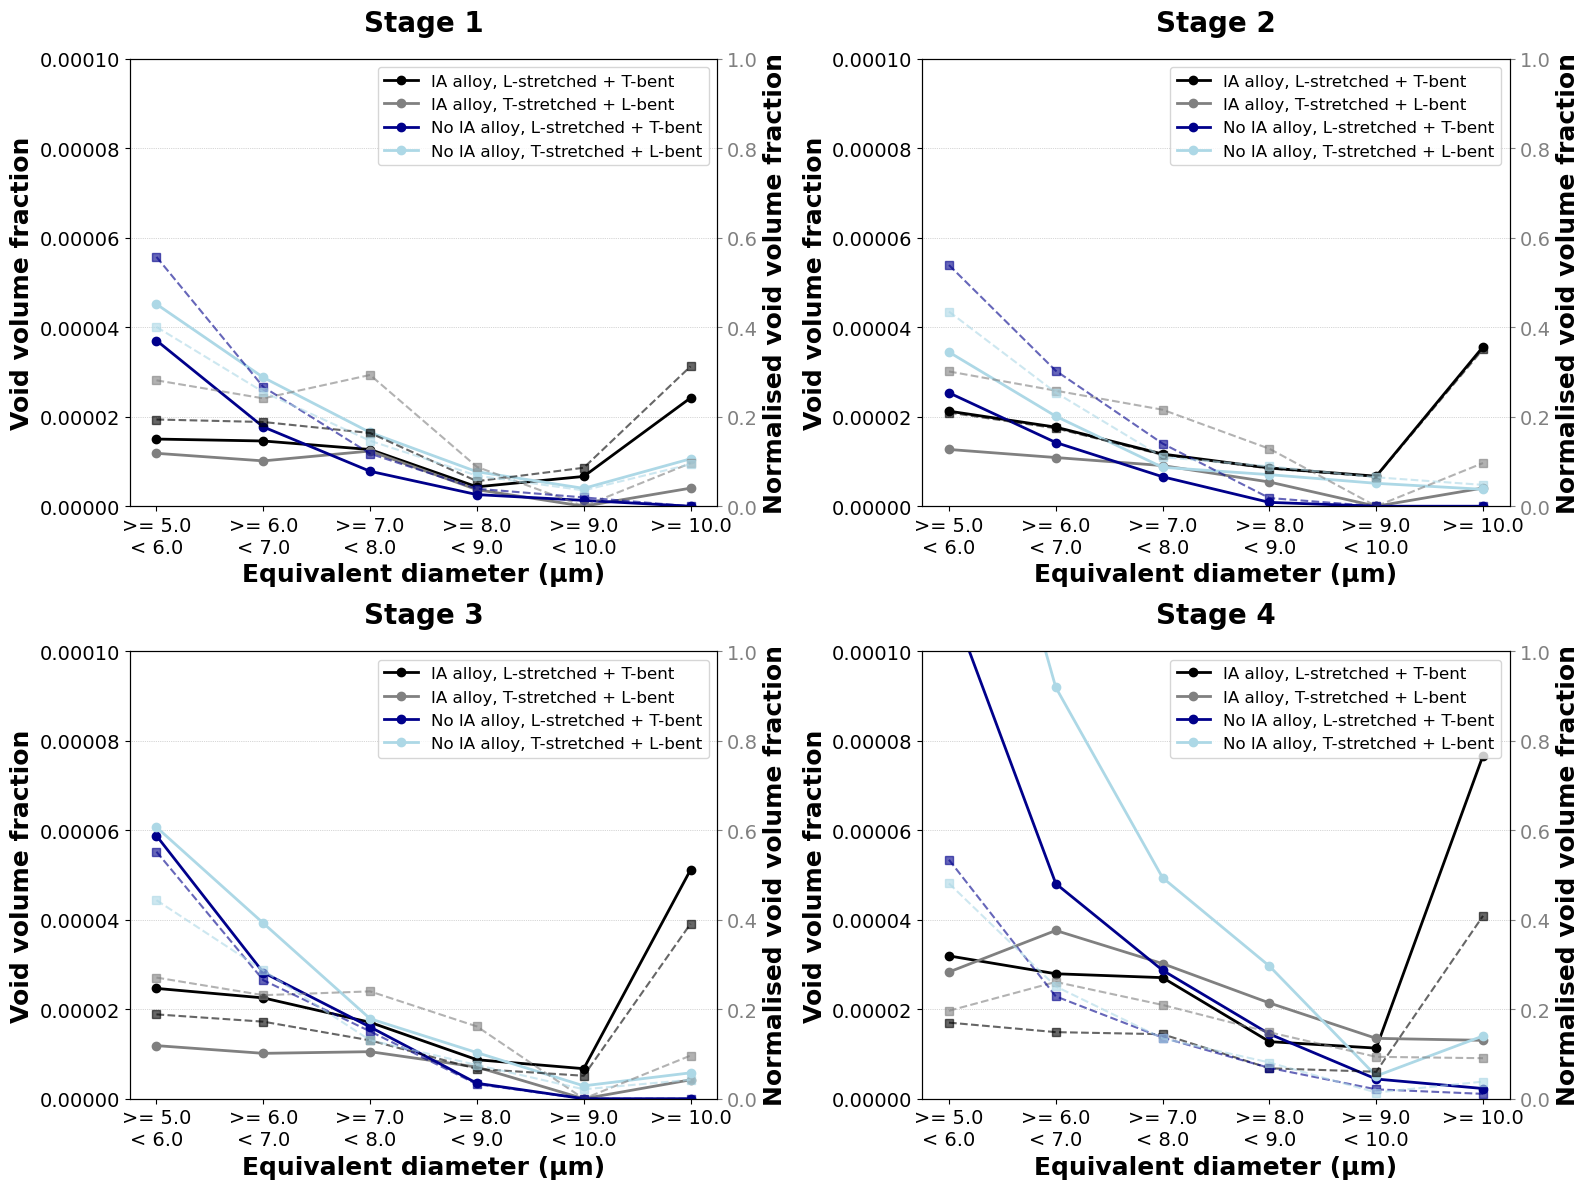

In [29]:
plot_void_volume_fraction_per_bin_grid(
    per_step_diameters,
    per_step_volume,
    per_step_sample_volume,
    steps=('step2','step3','step4','step5'),   
    ylim_abs=(0, 0.0001), 
    ylim_norm=(0, 1) 
)


C:\Users\lagon\AppData\Local\Temp\ipykernel_14008\1192621637.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, labels=stage_labels, patch_artist=True)
C:\Users\lagon\AppData\Local\Temp\ipykernel_14008\1192621637.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, labels=stage_labels, patch_artist=True)
C:\Users\lagon\AppData\Local\Temp\ipykernel_14008\1192621637.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, labels=stage_labels, patch_artist=True)
C:\Users\lagon\AppData\Local\Temp\ipykernel_14008\1192621637.py:38: MatplotlibDeprecationWarni

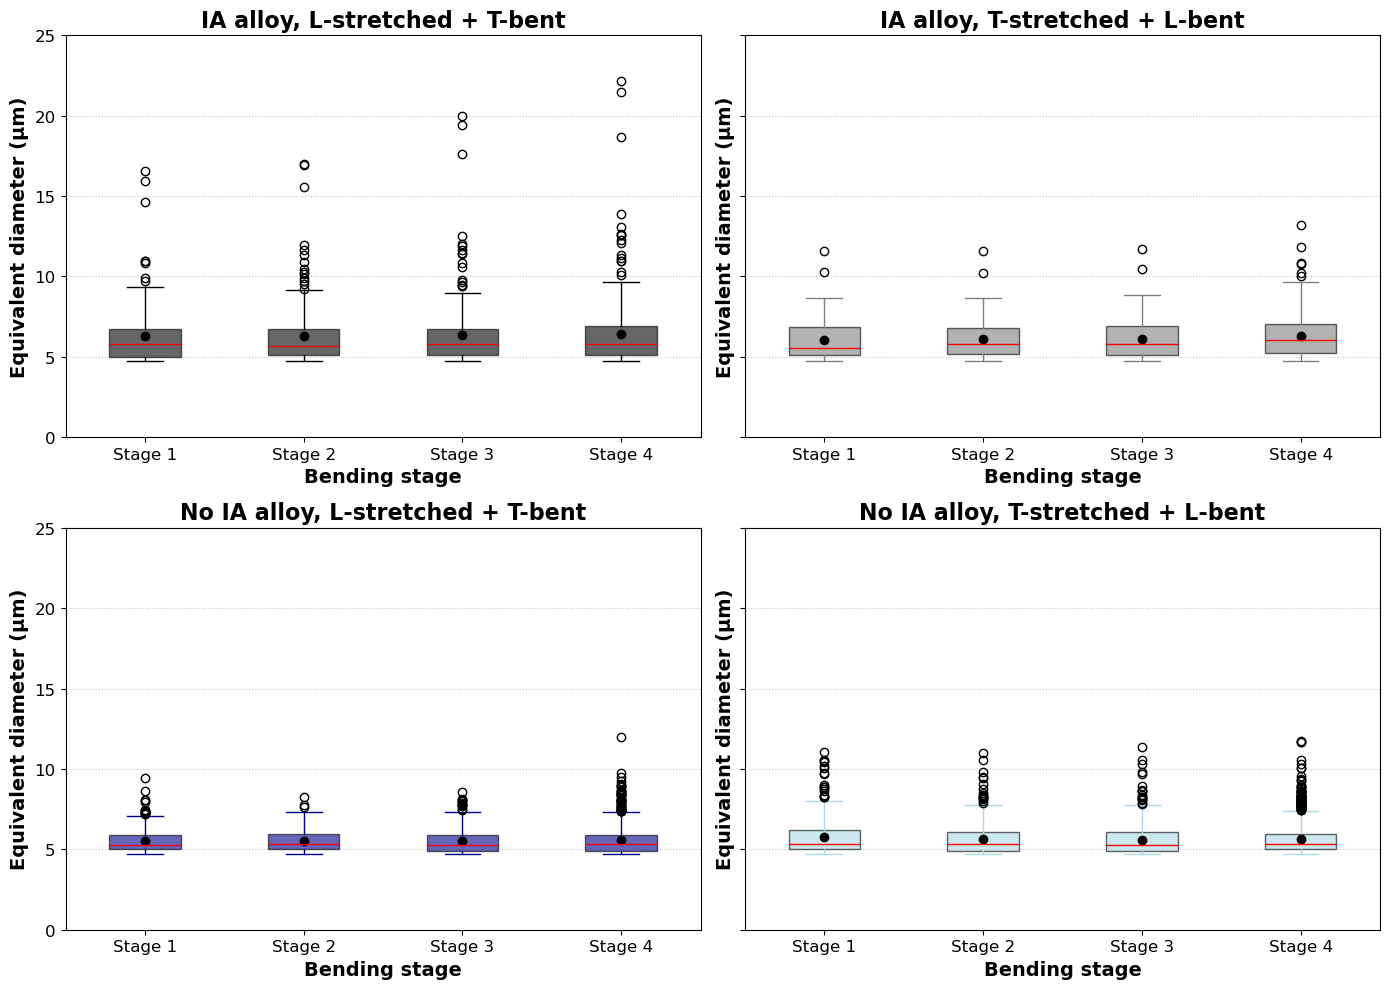

In [30]:
def plot_void_diameter_boxplots_grid(
    per_step_diameters,
    steps=('step2','step3','step4','step5'),
    ylim=(0, 25)
):

    sample_colors = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    sample_names = {
        "sample1": "IA alloy, L-stretched + T-bent",
        "sample2": "IA alloy, T-stretched + L-bent",
        "sample3": "No IA alloy, L-stretched + T-bent",
        "sample4": "No IA alloy, T-stretched + L-bent"
    }

    samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    axes = axes.flatten()

    for ax, s in zip(axes, samples):
        data = []
        stage_labels = []

        for i, step in enumerate(steps, start=1):
            diams = np.asarray(per_step_diameters.get(s, {}).get(step, []))
            diams = diams[np.isfinite(diams) & (diams > 0)]
            if diams.size > 0:
                data.append(diams)
                stage_labels.append(f"Stage {i}")  

        if data:
            box = ax.boxplot(data, labels=stage_labels, patch_artist=True)

            for patch in box['boxes']:
                patch.set_facecolor(sample_colors.get(s, "lightgrey"))
                patch.set_alpha(0.6)
            for whisker in box['whiskers']:
                whisker.set_color(sample_colors.get(s, "lightgrey"))
            for cap in box['caps']:
                cap.set_color(sample_colors.get(s, "lightgrey"))
            for median in box['medians']:
                median.set_color("red")

            means = [np.mean(d) for d in data]
            ax.plot(
                np.arange(1, len(data) + 1), means,
                marker='o', color='black', linestyle='None', label="Mean"
            )

            ax.set_title(sample_names.get(s, s), fontweight="bold", fontsize=16)

        else:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)

        ax.set_xlabel("Bending stage", fontweight="bold", fontsize=14)
        ax.set_ylabel("Equivalent diameter (µm)", fontweight="bold", fontsize=14)
        ax.set_ylim(*ylim)
        ax.grid(axis="y", linestyle=":", alpha=0.7)
        ax.tick_params(axis="both", labelsize=12)

    for ax in axes[len(samples):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.savefig("void_diameter_boxplots_grid.png", dpi=300, bbox_inches="tight")
    plt.show()


# Example call
plot_void_diameter_boxplots_grid(per_step_diameters)


C:\Users\lagon\AppData\Local\Temp\ipykernel_14008\4037874197.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, labels=stage_labels, patch_artist=True)
C:\Users\lagon\AppData\Local\Temp\ipykernel_14008\4037874197.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, labels=stage_labels, patch_artist=True)
C:\Users\lagon\AppData\Local\Temp\ipykernel_14008\4037874197.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, labels=stage_labels, patch_artist=True)
C:\Users\lagon\AppData\Local\Temp\ipykernel_14008\4037874197.py:38: MatplotlibDeprecationWarni

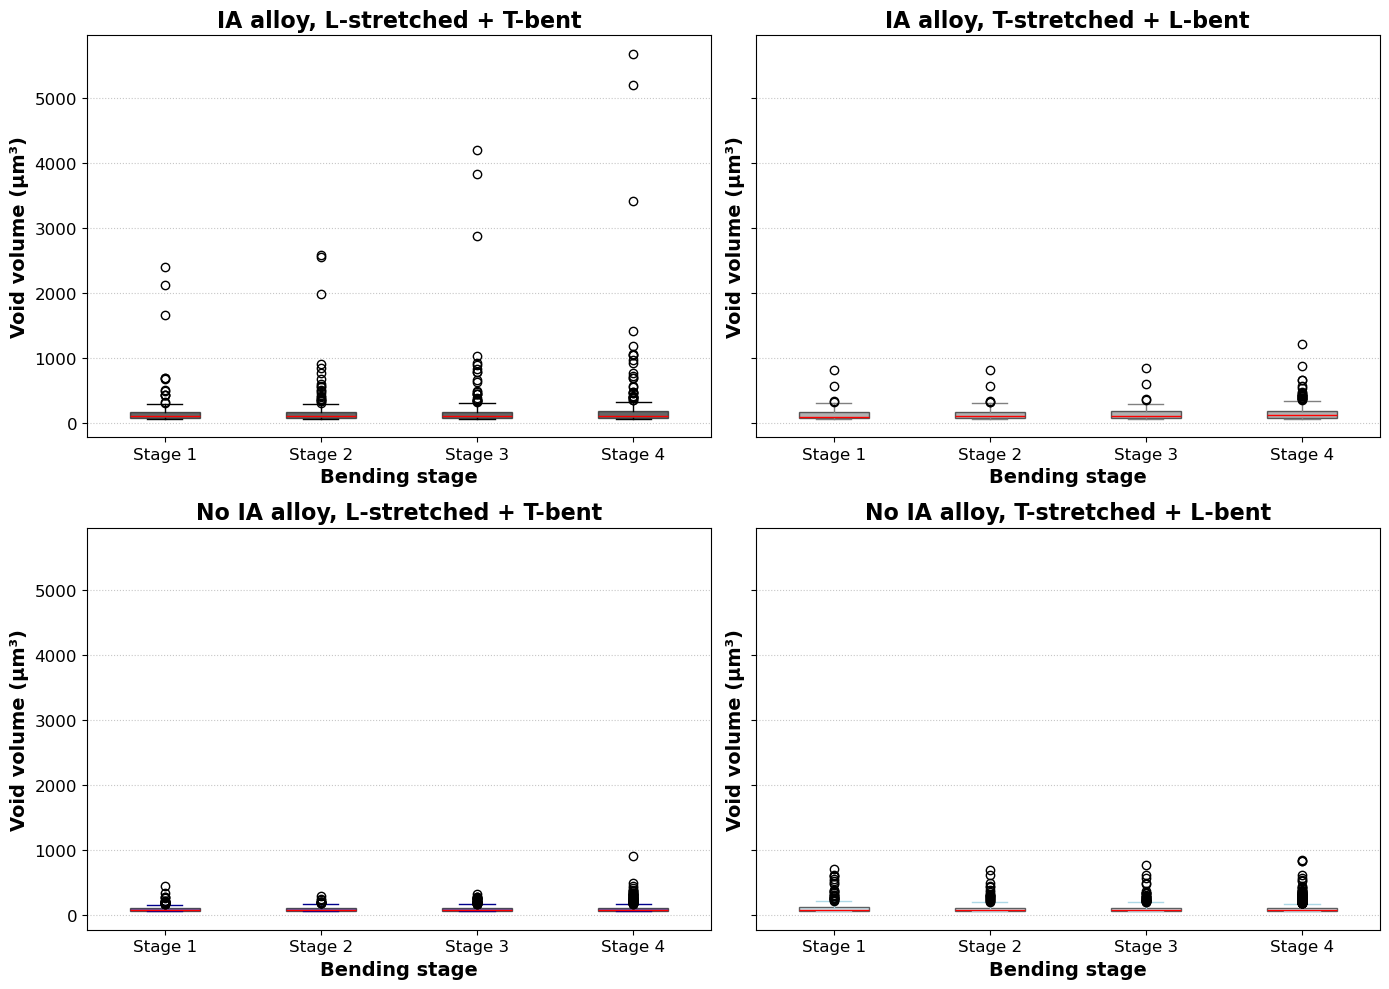

In [31]:
def plot_void_volume_boxplots_grid(
    per_step_volume,
    steps=('step2','step3','step4','step5'),
    ylim=None,          
    log_y=False         
):
    sample_colors = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }

    sample_names = {
        "sample1": "IA alloy, L-stretched + T-bent",
        "sample2": "IA alloy, T-stretched + L-bent",
        "sample3": "No IA alloy, L-stretched + T-bent",
        "sample4": "No IA alloy, T-stretched + L-bent"
    }

    samples = sorted(per_step_volume.keys(), key=lambda s: int(s.replace('sample','')))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=not log_y)
    axes = axes.flatten()

    for ax, s in zip(axes, samples):
        data = []
        stage_labels = []

        for i, step in enumerate(steps, start=1):
            vols = np.asarray(per_step_volume.get(s, {}).get(step, []))
            vols = vols[np.isfinite(vols) & (vols > 0)]
            if vols.size > 0:
                data.append(vols)
                stage_labels.append(f"Stage {i}")

        if data:
            box = ax.boxplot(data, labels=stage_labels, patch_artist=True)

            # colour per sample
            col = sample_colors.get(s, "lightgrey")
            for patch in box['boxes']:
                patch.set_facecolor(col)
                patch.set_alpha(0.6)
            for whisker in box['whiskers']:
                whisker.set_color(col)
            for cap in box['caps']:
                cap.set_color(col)
            for median in box['medians']:
                median.set_color("red")

            ax.set_title(sample_names.get(s, s), fontweight="bold", fontsize=16)
        else:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes,
                    ha="center", va="center", fontsize=14)

        ax.set_xlabel("Bending stage", fontweight="bold", fontsize=14)
        ax.set_ylabel("Void volume (µm³)", fontweight="bold", fontsize=14)

        if log_y:
            ax.set_yscale('log')
        if ylim is not None and not log_y:
            ax.set_ylim(*ylim)

        ax.grid(axis="y", linestyle=":", alpha=0.7)
        ax.tick_params(axis="both", labelsize=12)

    for ax in axes[len(samples):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.savefig("void_volume_boxplots_grid.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_void_volume_boxplots_grid(per_step_volume, steps=('step2','step3','step4','step5'))


In [32]:
def plot_cumulative_equiv_diameter_grid(
    per_step_diameters,
    steps=('step2','step3','step4','step5'),
    xlim=None,              
    ylim=None,                
    figsize=(14, 10)
):

    sample_colors = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }
    sample_names = {
        "sample1": "IA alloy, L-stretched + T-bent",
        "sample2": "IA alloy, T-stretched + L-bent",
        "sample3": "No IA alloy, L-stretched + T-bent",
        "sample4": "No IA alloy, T-stretched + L-bent"
    }

    samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    axes = axes.flatten()

    for idx, (ax, step_key) in enumerate(zip(axes, steps), start=1):
        plotted_any = False

        for s in samples:
            diams = np.asarray(per_step_diameters.get(s, {}).get(step_key, []))
            diams = diams[np.isfinite(diams) & (diams > 0)]
            if diams.size == 0:
                continue

            x_sorted = np.sort(diams)
            y_cum = np.arange(1, x_sorted.size + 1) / x_sorted.size

            ax.plot(
                x_sorted, y_cum,
                linewidth=2,
                color=sample_colors.get(s, None),
                label=sample_names.get(s, s)
            )
            plotted_any = True

        if not plotted_any:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes,
                    ha='center', va='center', fontsize=12, alpha=0.7)
        else:
            ax.legend(loc='lower right', frameon=True, fontsize=11)

        ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=14)
        ax.set_ylabel("Cumulative number of voids", fontweight='bold', fontsize=14)
        ax.set_ylim(0, 1.0)
        if xlim is not None:
            ax.set_xlim(*xlim)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.8)
        ax.tick_params(axis='both', labelsize=12)

        ax.set_title(f"Stage {idx}", fontsize=16, fontweight='bold', pad=14)

    for ax in axes[len(steps):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.savefig("cumulative_equiv_diameter_grid.png", dpi=300, bbox_inches="tight")
    plt.show()


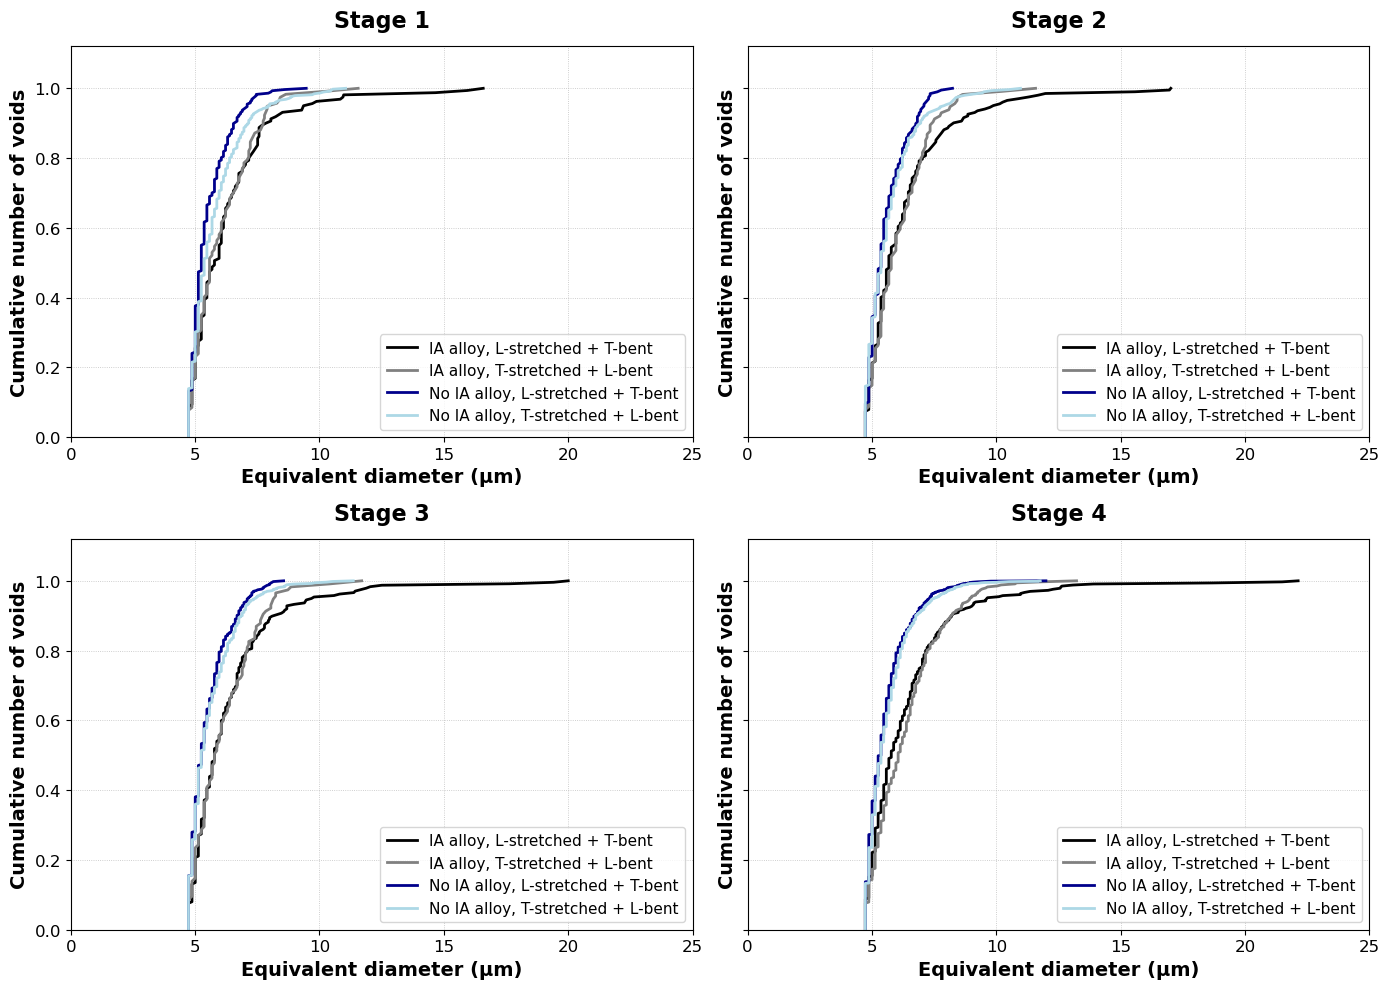

In [33]:
plot_cumulative_equiv_diameter_grid(
    per_step_diameters,
    steps=('step2','step3','step4','step5'),
    xlim=(0, 25),
    ylim=(0, 1.12)
)


In [34]:
def plot_cumulative_equiv_diameter_grid(
    per_step_diameters,
    steps=('step2','step3','step4','step5'),
    xlim=None,
    ylim=None,
    figsize=(14, 10)
):


    sample_colors = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }
    sample_names = {
        "sample1": "IA alloy, L-stretched + T-bent",
        "sample2": "IA alloy, T-stretched + L-bent",
        "sample3": "No IA alloy, L-stretched + T-bent",
        "sample4": "No IA alloy, T-stretched + L-bent"
    }

    samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    axes = axes.flatten()

    for idx, (ax, step_key) in enumerate(zip(axes, steps), start=1):
        plotted_any = False

        for s in samples:
            diams = np.asarray(per_step_diameters.get(s, {}).get(step_key, []))
            diams = diams[np.isfinite(diams) & (diams > 0)]
            if diams.size == 0:
                continue

            x_sorted = np.sort(diams)
            y_cum = np.arange(1, x_sorted.size + 1) / x_sorted.size

            ax.plot(
                x_sorted, y_cum,
                linewidth=2,
                color=sample_colors.get(s, None),
                label=sample_names.get(s, s)
            )
            plotted_any = True

        if not plotted_any:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes,
                    ha='center', va='center', fontsize=12, alpha=0.7)
        else:
            ax.legend(loc='lower right', frameon=True, fontsize=10)

        ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=14)
        ax.set_ylabel("Cumulative void number fraction", fontweight='bold', fontsize=14)
        ax.set_ylim(0, 1.0)
        if xlim is not None:
            ax.set_xlim(*xlim)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.8)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_title(f"Stage {idx}", fontsize=16, fontweight='bold', pad=14)

    for ax in axes[len(steps):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.savefig("cumulative_equiv_diameter_grid.png", dpi=300, bbox_inches="tight")
    plt.show()


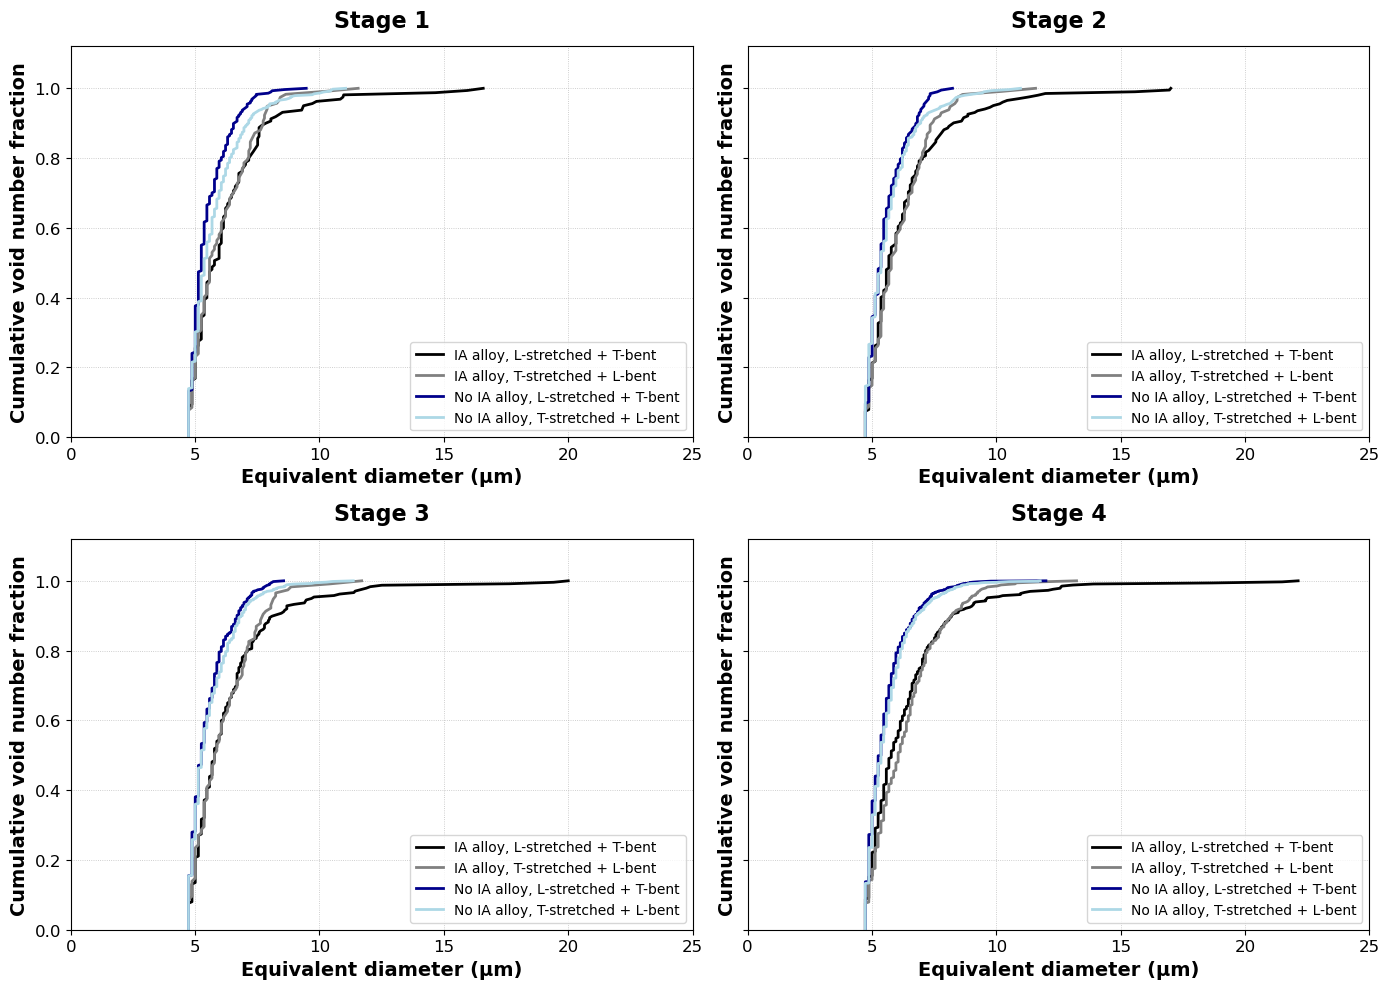

In [35]:
plot_cumulative_equiv_diameter_grid(per_step_diameters, ylim=(0, 1.12), xlim=(0, 25))


In [36]:
def plot_cumulative_equiv_diameter_allstages(
    per_step_diameters,
    steps=('step2','step3','step4','step5'),
    xlim=None,                
    ylim=(0.0, 1.0),
    figsize=(9, 7),
    marker_every=20
):
    sample_colors = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }
    sample_names = {
        "sample1": "IA alloy, L-stretched + T-bent",
        "sample2": "IA alloy, T-stretched + L-bent",
        "sample3": "No IA alloy, L-stretched + T-bent",
        "sample4": "No IA alloy, T-stretched + L-bent"
    }

    stage_styles = {
        'step2': dict(marker='o',  linestyle='-',  dash_capstyle='round'),
        'step3': dict(marker='s',  linestyle='-',  dash_capstyle='round'),
        'step4': dict(marker='^',  linestyle='-.', dash_capstyle='round'),
        'step5': dict(marker='D',  linestyle='-',  dash_capstyle='round'),
    }
    stage_labels = {k: f"Stage {i+1}" for i, k in enumerate(steps)}

    samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))
    fig, ax = plt.subplots(figsize=figsize)

    for s in samples:
        color = sample_colors.get(s, None)
        for st in steps:
            diams = np.asarray(per_step_diameters.get(s, {}).get(st, []))
            diams = diams[np.isfinite(diams) & (diams > 0)]
            if diams.size == 0:
                continue

            x_sorted = np.sort(diams)
            y_cum = np.arange(1, x_sorted.size + 1) / x_sorted.size
            style = stage_styles.get(st, dict(marker=None, linestyle='-'))

            ax.plot(x_sorted, y_cum, color=color, linewidth=2, linestyle=style["linestyle"])
            ax.plot(
                x_sorted[::marker_every], y_cum[::marker_every],
                color=color,
                linestyle="None",
                marker=style["marker"],
                markersize=8
            )

    ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=18)
    ax.set_ylabel("Cumulative void number fraction", fontweight='bold', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)

    if ylim is not None:
        ax.set_ylim(*ylim)
    if xlim is not None:
        ax.set_xlim(*xlim)

    ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.8)

    sample_handles = [Line2D([0], [0], color=sample_colors[k], linewidth=3, label=sample_names.get(k, k))
                      for k in samples]
    stage_handles = [Line2D([0], [0],
                            color='k', linewidth=2, markersize=8,
                            marker=stage_styles[st].get('marker', None),
                            linestyle=stage_styles[st].get('linestyle', '-'),
                            label=stage_labels.get(st, st))
                     for st in steps]

    leg1 = ax.legend(handles=sample_handles, loc='center right', frameon=True, fontsize=14, title_fontsize=16)
    ax.add_artist(leg1)
    ax.legend(handles=stage_handles, loc='lower right', frameon=True, fontsize=14, title="Bending stage", title_fontsize=16)

    plt.tight_layout()
    plt.savefig("cumulative_equiv_diameter_allstages.png", dpi=300, bbox_inches="tight")
    plt.show()


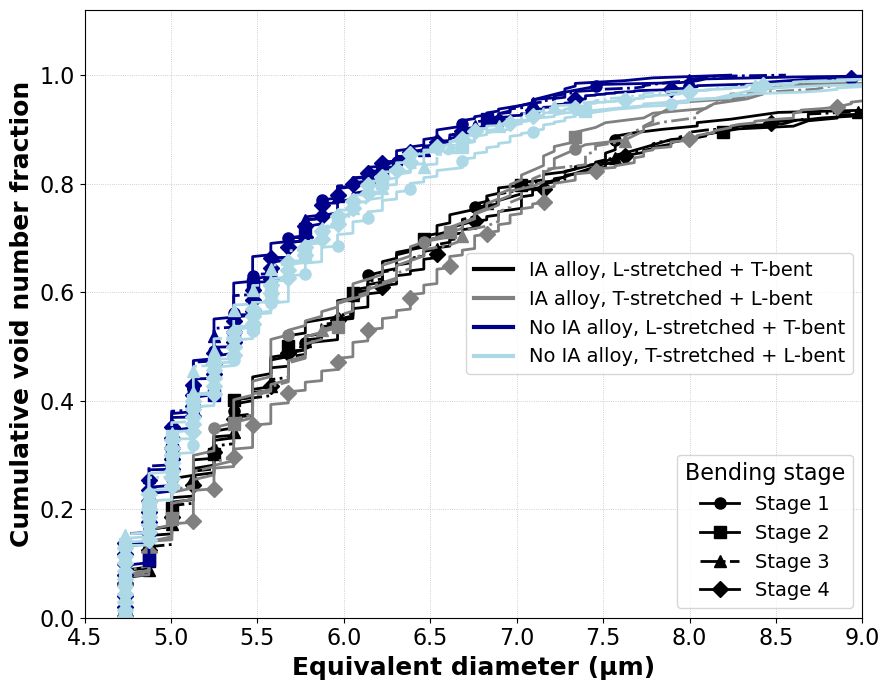

In [37]:
plot_cumulative_equiv_diameter_allstages(
    per_step_diameters,
    steps=('step2','step3','step4','step5'),
    xlim=(4.5, 9),
    ylim=(0.0, 1.120)
)


In [38]:
def plot_cumulative_void_volume_fraction_grid(
    per_step_diameters,
    per_step_volume,            
    steps=('step2','step3','step4','step5'),
    xlim=None,
    ylim=None,
    figsize=(14, 10)
):


    sample_colors = {
        'sample1': 'black',
        'sample2': 'grey',
        'sample3': 'darkblue',
        'sample4': 'lightblue'
    }
    sample_names = {
        "sample1": "IA alloy, L-stretched + T-bent",
        "sample2": "IA alloy, T-stretched + L-bent",
        "sample3": "No IA alloy, L-stretched + T-bent",
        "sample4": "No IA alloy, T-stretched + L-bent"
    }

    samples = sorted(per_step_diameters.keys(), key=lambda s: int(s.replace('sample','')))
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    axes = axes.flatten()

    for idx, (ax, step_key) in enumerate(zip(axes, steps), start=1):
        plotted_any = False

        for s in samples:
            diams = np.asarray(per_step_diameters.get(s, {}).get(step_key, []))
            vols  = np.asarray(per_step_volume.get(s, {}).get(step_key, []))
            mask = np.isfinite(diams) & (diams > 0) & np.isfinite(vols) & (vols > 0)

            diams, vols = diams[mask], vols[mask]
            if diams.size == 0:
                continue

            order = np.argsort(diams)
            x_sorted = diams[order]
            v_sorted = vols[order]

            cum_vol = np.cumsum(v_sorted)
            y_cum = cum_vol / cum_vol[-1] 

            ax.plot(
                x_sorted, y_cum,
                linewidth=2,
                color=sample_colors.get(s, None),
                label=sample_names.get(s, s)
            )
            plotted_any = True

        if not plotted_any:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes,
                    ha='center', va='center', fontsize=12, alpha=0.7)
        else:
            ax.legend(loc='lower right', frameon=True, fontsize=12)

        ax.set_xlabel("Equivalent diameter (µm)", fontweight='bold', fontsize=14)
        ax.set_ylabel("Cumulative void volume fraction", fontweight='bold', fontsize=14)
        ax.set_ylim(0, 1.0)
        if xlim is not None:
            ax.set_xlim(*xlim)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.8)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_title(f"Stage {idx}", fontsize=16, fontweight='bold', pad=14)

    for ax in axes[len(steps):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.savefig("cumulative_void_volume_fraction_grid.png", dpi=300, bbox_inches="tight")
    plt.show()


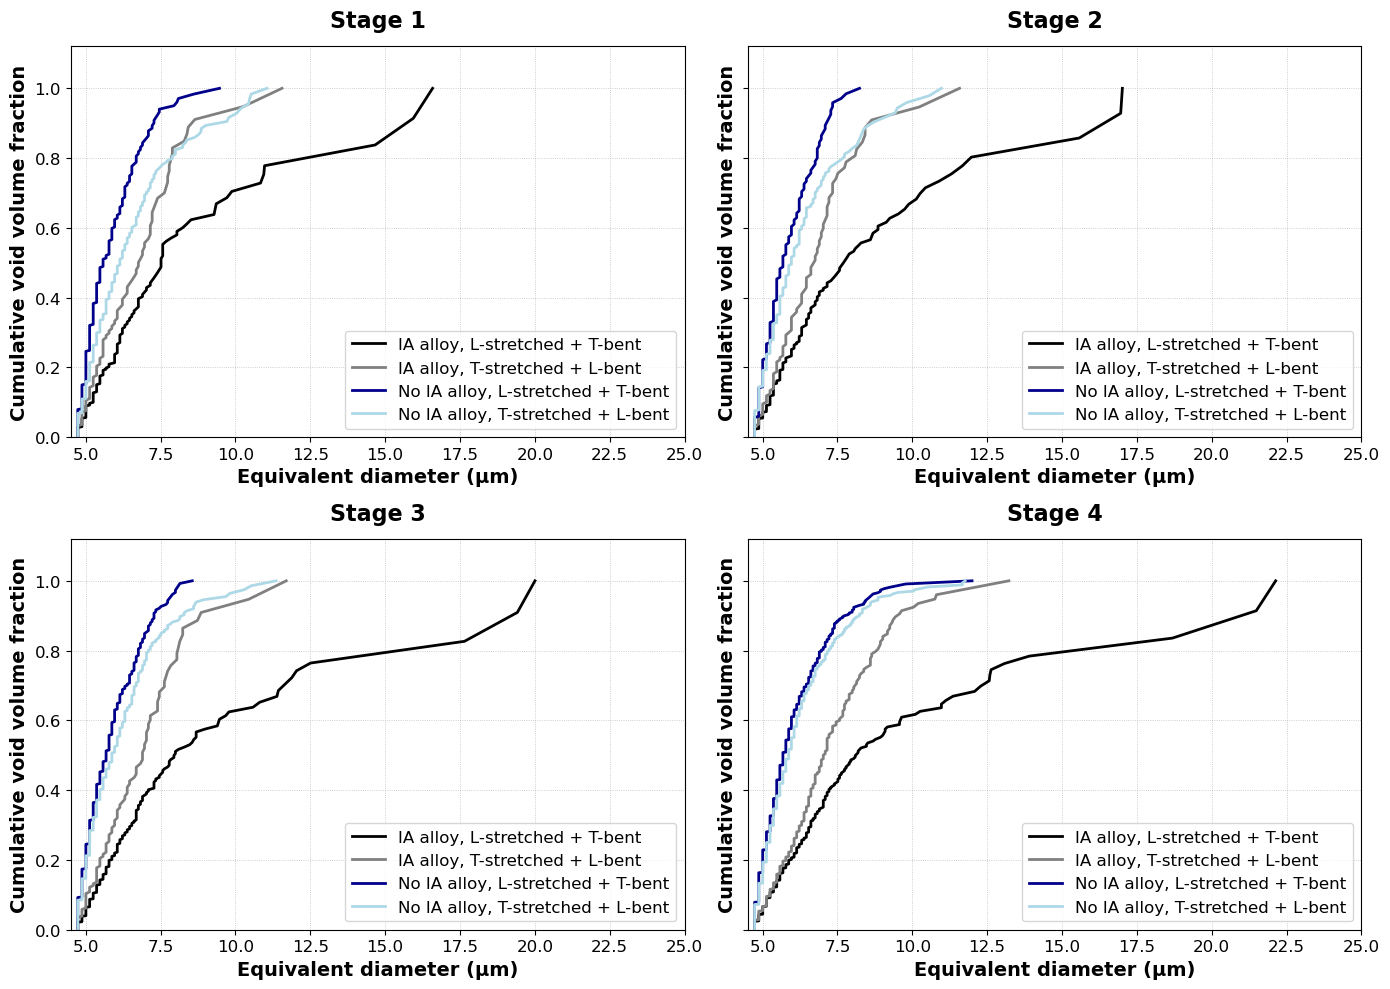

In [39]:
plot_cumulative_void_volume_fraction_grid(
    per_step_diameters,
    per_step_volume,
    steps=('step2', 'step3', 'step4', 'step5'),
    xlim=(4.5, 25),   
    ylim=(0, 1.120)    
)
